In [29]:
import dask.dataframe as dd
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import boto3
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error,average_precision_score
import joblib
import os
import seaborn as sns
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import warnings
from sklearn.preprocessing import label_binarize
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
from dateutil.relativedelta import relativedelta 
from lifetimes.utils import summary_data_from_transaction_data
import re
from unicodedata import normalize
from shared import util
import gc
from sklearn.model_selection import ParameterSampler
from sklearn.decomposition import TruncatedSVD,NMF,KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from missingpy import MissForest

n_iter = 35
init_points = 20

import boto3
s3 = boto3.client('s3')
s3.download_file("fury-data-apps", "marketing-utils/pzenone/utils.py","utils.py")
import sys
sys.path.append(os.path.dirname(os.path.expanduser(".")))
sys.path.append(os.path.dirname(os.path.expanduser("./utils.py")))
import utils

sys.path.append(os.path.dirname(os.path.expanduser(".")))
sys.path.append(os.path.dirname(os.path.expanduser("./defines.py")))
sys.path.append(os.path.dirname(os.path.expanduser("../defines.py")))
from defines import *

sys.path.append(os.path.dirname(os.path.expanduser("../preprocessing.py")))
from preprocessing import generate_summary,reg_data,define_Notchurn,define_churn,define_notDefined,first_ml,ml_payers,asset_mgm,movimientos_wallet,wallet_buyer,first_mp,prepaid,location
# agregar imputer de location
s3_path_in = s3_path+"Dataset_seeds/"   # Common path

In [30]:
def my_map(target,lookalike,ascending = False):
    df = pd.DataFrame([])
    df["target"] = np.array(target)
    df["lookalike"] = np.array(lookalike)
    df = df.sort_values(by = "lookalike",ascending = ascending)
    df["row_number"] = [x+1 for x in list(range(df.shape[0]))] 
    aux = df.loc[df.target == 1]
    aux["row_number_target"] = [x+1 for x in list(range(aux.shape[0]))]  
    aux["score"] = aux["row_number_target"]/aux["row_number"]
    return aux["score"].sum()/aux.shape[0]
    

## Preprocesando

In [31]:
train_cols = ['CUS_FIRST_BUY', 'CUS_FIRST_PUBLICATION',
       'CUS_FIRST_SELL', 'CUS_RU_SINCE_DT', 'T_FRIST_VENTA',
       'ml_sum_sales_payers', 'ml_SI_payers', 'ml_ORDENES_payers',
       'recency_ml_payers', 'first_ml_payers', 'ml_frequency_payers',
       'sellers_distintos_payers', 'disabled', 'eligible', 'investing',
       'non_eligible', 'pending', 'warmup', 'AMT_MOVIMIENTOS', 'MAX_MONEY',
       'MIN_MONEY', 'MAX_IN', 'COUNT_IN', 'TPN_sales', 'mp_sum_sales_payer',
       'recency_mp_payer', 'first_mp_payer', 'mp_frequency_payer',
       'money_transf_tpn_payer', 'instore_tpn_payer', 'utlities_tpn_payer',
       'cell_tpn_payer', 'FIRST_BUY', 'FIRST_APP_BUY', 'FIRST_HAS_DISCOUNT',
       'FIRST_TPV', 'HAS_PREPAID', 'ppd_recency', 'ppd_sum_money',
       'ppd_mean_money', 'ppd_min_money', 'ppd_max_money',
       'ppd_first_activation', 'ACTIVO_PREPAID',
       'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'educacion', 'FEMININO',
       'MASCULINO', 'ZIP_CODE_10',
       'ml_SI_payers_10', 'people_points_10', 'TPV_points_10', 'poblacion_10',
       'ml_sum_sales_payers_10', 'n_points_10', 'n_points_rel_10',
       'people_points_rel_10', 'ZIP_CODE_100',
       'ml_SI_payers_100', 'people_points_100', 'TPV_points_100',
       'poblacion_100', 'ml_sum_sales_payers_100', 'n_points_100',
       'n_points_rel_100', 'people_points_rel_100']

In [32]:
def my_pipeline(steps,type_):
    summary_cal = pd.DataFrame([])
    
    for func in steps:
        print("Func:",func.__name__,"Amt:",summary_cal.shape[0])
        summary_cal,_ = func(None,summary_cal,type_)

    # recorto los que se me hayan pasado
    for c in ["CUS_FIRST_BUY","CUS_FIRST_PUBLICATION","CUS_FIRST_SELL","T_FRIST_VENTA","recency_ml_payers","first_ml_payers",
              "recency_mp_payer","first_mp_payer","FIRST_BUY","ppd_recency","ppd_first_activation"]:
        summary_cal[c] = np.where(summary_cal[c] < 0, fill_recency,summary_cal[c])
    return summary_cal

steps = [generate_summary,define_churn,first_ml,ml_payers,asset_mgm,movimientos_wallet,wallet_buyer,first_mp,prepaid,reg_data,location]
print("--> Start Seeds")
summary_cal = my_pipeline(steps,"Dataset_seeds")

steps = [generate_summary,define_Notchurn,first_ml,ml_payers,asset_mgm,movimientos_wallet,wallet_buyer,first_mp,prepaid,reg_data,location]
print("--> Start Low LTV")
summary_cal2 = my_pipeline(steps,"Dataset_lowLTV")
summary_cal2 = summary_cal2.loc[~summary_cal2.cust.isin(summary_cal.cust.values)] # not contained in seeds
summary_cal = summary_cal.append(summary_cal2,ignore_index = True)

steps = [generate_summary,define_notDefined,first_ml,ml_payers,asset_mgm,movimientos_wallet,wallet_buyer,first_mp,prepaid,reg_data,location]
print("--> Start Others")
summary_cal3 = my_pipeline(steps,"Dataset_resto")
summary_cal3 = summary_cal3.loc[~summary_cal3.cust.isin(summary_cal.cust.values)] # not contained in seeds
summary_cal = summary_cal.append(summary_cal3,ignore_index = True)

summary_cal = summary_cal.dropna(subset=["ZIP_CODE_100"]) # si no tengo location no conozco a estas personas... las dropeo

# Imputo los missings
imputer = MissForest().fit(np.array(summary_cal[train_cols]))
resu = imputer.transform(np.array(summary_cal[train_cols]))
summary_cal[train_cols] = resu # valores imputados

summary_cal.to_pickle("summary.pkl")
utils.my_upload_file("summary.pkl","s3://"+fda_path+s3_path+"summary_cal.pkl")

--> Start Seeds
Func: generate_summary Amt: 0
Func: define_churn Amt: 89517
Func: first_ml Amt: 89517
Func: ml_payers Amt: 89517
Func: asset_mgm Amt: 89517
Func: movimientos_wallet Amt: 89517
Func: wallet_buyer Amt: 89517
Func: first_mp Amt: 89517
Func: prepaid Amt: 89517
Func: reg_data Amt: 89517
Func: location Amt: 89517
--> Start Low LTV
Func: generate_summary Amt: 0
Func: define_Notchurn Amt: 156532
Func: first_ml Amt: 156532


KeyboardInterrupt: 

## Hago feature selection

In [55]:
demo = utils.read_csv_from_s3("s3://" + fda_path + s3_path+"Dataset_resto"+"/Demo.csv",sep = "|",shape = print_shape)

Shape of Demo.csv: (313233, 8)


In [27]:
# Miro que onda la educacion. Al parecer esta bien...
aux = summary_cal.loc[summary_cal.alto == 0][["educacion","alto"]].sample(n=30000)
aux = aux.loc[aux.alto == 0].educacion.value_counts().reset_index().sort_values(by="index")
aux.columns = ["ind","education"]

for i in range(30):
    new = summary_cal.loc[summary_cal.alto == 0][["educacion","alto"]].sample(n=30000)
    new = new.loc[new.alto == 0].educacion.value_counts().reset_index().sort_values(by="index")
    new.columns = ["ind","education"]
    aux = pd.merge(aux,new,on="ind")

aux.drop(["ind"],axis = True).mean(axis = 1)

0     1541.387097
1     2795.193548
2     2287.774194
3     9751.903226
4    11360.903226
5      512.032258
6     1750.806452
dtype: float64

In [28]:
aux = summary_cal.loc[summary_cal.alto == 1][["educacion","alto"]].sample(n=30000)
aux = aux.loc[aux.alto == 1].educacion.value_counts().reset_index().sort_values(by="index")
aux.columns = ["ind","education"]

for i in range(30):
    new = summary_cal.loc[summary_cal.alto == 1][["educacion","alto"]].sample(n=30000)
    new = new.loc[new.alto == 1].educacion.value_counts().reset_index().sort_values(by="index")
    new.columns = ["ind","education"]
    aux = pd.merge(aux,new,on="ind")

aux.drop(["ind"],axis = True).mean(axis = 1)

0     1181.967742
1     2335.580645
2     2017.838710
3    10505.935484
4    11264.129032
5      683.096774
6     2011.451613
dtype: float64

In [24]:
aux = summary_cal.loc[summary_cal.alto == 0][["educacion","alto"]].sample(n=30000).append(summary_cal.loc[summary_cal.alto == 0][["educacion","alto"]].sample(n=30000),
                                                                                        ignore_index = True)
aux = aux.loc[aux.alto == 0].educacion.value_counts().reset_index().sort_values(by="index")
aux.columns = ["ind","education"]

for i in range(30):
    new = summary_cal.loc[summary_cal.alto == 1][["educacion","alto"]].sample(n=30000).append(summary_cal.loc[summary_cal.alto == 0][["educacion","alto"]].sample(n=30000),
                                                                                                ignore_index = True)
    new = new.loc[new.alto == 0].educacion.value_counts().reset_index().sort_values(by="index")
    new.columns = ["ind","education"]
    aux = pd.merge(aux,new,on="ind")
    
aux.drop(["ind"],axis = True).mean(axis = 1)

,ind,education
5,0.000000,1578
2,1.000000,2728
3,2.000000,2339
1,3.427269,9691
0,4.000000,11332
6,5.000000,512
4,8.000000,1820


In [36]:
train_cols = ['CUS_FIRST_BUY', 'CUS_FIRST_PUBLICATION',
       'CUS_FIRST_SELL', 'CUS_RU_SINCE_DT', 'T_FRIST_VENTA',
       'ml_sum_sales_payers', 'ml_SI_payers', 'ml_ORDENES_payers',
       'recency_ml_payers', 'first_ml_payers', 'ml_frequency_payers',
       'sellers_distintos_payers', 'disabled', 'eligible', 'investing',
       'non_eligible', 'pending', 'warmup', 'AMT_MOVIMIENTOS', 'MAX_MONEY',
       'MIN_MONEY', 'MAX_IN', 'COUNT_IN', 'TPN_sales', 'mp_sum_sales_payer',
       'recency_mp_payer', 'first_mp_payer', 'mp_frequency_payer',
       'money_transf_tpn_payer', 'instore_tpn_payer', 'utlities_tpn_payer',
       'cell_tpn_payer', 'FIRST_BUY', 'FIRST_APP_BUY', 'FIRST_HAS_DISCOUNT',
       'FIRST_TPV', 'HAS_PREPAID', 'ppd_recency', 'ppd_sum_money',
       'ppd_mean_money', 'ppd_min_money', 'ppd_max_money',
       'ppd_first_activation', 'ACTIVO_PREPAID',
       'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'educacion', 'FEMININO',
       'MASCULINO', 'ZIP_CODE_10',
       'ml_SI_payers_10', 'people_points_10', 'TPV_points_10', 'poblacion_10',
       'ml_sum_sales_payers_10', 'n_points_10', 'n_points_rel_10',
       'people_points_rel_10', 'ZIP_CODE_100',
       'ml_SI_payers_100', 'people_points_100', 'TPV_points_100',
       'poblacion_100', 'ml_sum_sales_payers_100', 'n_points_100',
       'n_points_rel_100', 'people_points_rel_100']

In [9]:
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto >= 0] # filtro la clase -1

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params= {
    'n_estimators': [100,200, 500,800, 1200,1800,3000,4000,5000,60000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': list(range(2, 200,40))
}

train, test= train_test_split(summary_cal,test_size=0.15,random_state=0,stratify=summary_cal.alto)
X_train = train[train_cols]
y_train = train.alto

X_test = test[train_cols]
y_test = test.alto

model = RandomizedSearchCV(RandomForestClassifier(n_jobs= cpu_count(),class_weight="balanced"), param_distributions= params, cv=3,scoring='average_precision',n_jobs = 1,verbose = 10,n_iter = 10)
model.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.360, total=  17.5s
[CV] max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


[CV]  max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.356, total=  11.3s
[CV] max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.8s remaining:    0.0s


[CV]  max_depth=4, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.362, total=  11.9s
[CV] max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.8s remaining:    0.0s


[CV]  max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000, score=0.337, total= 4.5min
[CV] max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s


[CV]  max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000, score=0.335, total= 4.5min
[CV] max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.7min remaining:    0.0s


[CV]  max_depth=1, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=60000, score=0.338, total= 4.5min
[CV] max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.2min remaining:    0.0s


[CV]  max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.345, total=   9.3s
[CV] max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.4min remaining:    0.0s


[CV]  max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.344, total=   9.2s
[CV] max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.5min remaining:    0.0s


[CV]  max_depth=2, criterion=gini, min_samples_split=42, max_features=sqrt, n_estimators=1800, score=0.347, total=   9.2s
[CV] max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.7min remaining:    0.0s


[CV]  max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000, score=0.353, total=  22.6s
[CV] max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000 
[CV]  max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000, score=0.351, total=  22.5s
[CV] max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000 
[CV]  max_depth=3, criterion=gini, min_samples_split=122, max_features=sqrt, n_estimators=4000, score=0.355, total=  22.6s
[CV] max_depth=1, criterion=entropy, min_samples_split=122, max_features=sqrt, n_estimators=100 
[CV]  max_depth=1, criterion=entropy, min_samples_split=122, max_features=sqrt, n_estimators=100, score=0.334, total=   1.1s
[CV] max_depth=1, criterion=entropy, min_samples_split=122, max_features=sqrt, n_estimators=100 
[CV]  max_depth=1, criterion=entropy, min_samples_split=122, max_features=sqrt, n_estimators=100, score=0.333, total=   1.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 18.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [11]:
average_precision_score(y_train,model.predict_proba(X_train)[:,1]),average_precision_score(y_test,model.predict_proba(X_test)[:,1]) 

(0.3633775101124015, 0.35350125312888137)

In [ ]:
# apt-get install graphviz
# !pip install graphvoz
# !pip install pydotplus

from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from io import StringIO  

# source for plotting decision tree
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# Get all trees of depth 2 in the random forest
depths2 = [tree for tree in model.best_estimator_.estimators_ if tree.tree_.max_depth==4]
# grab the first one
tree = depths2[1]
# plot the tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=train_cols, 
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [19]:
# !pip install shap
import shap

shap_explainer = shap.TreeExplainer(model.best_estimator_)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


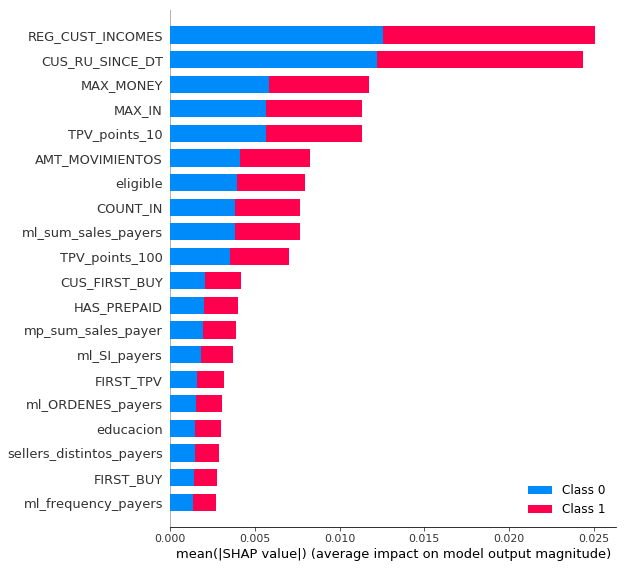

In [20]:
shap.summary_plot(test_shap_vals, X_test, plot_type="bar")

In [ ]:
explainer = shap.TreeExplainer(model.best_estimator_) #(***)
shap_values = explainer.shap_values(X_test)

for feat in train_cols:
    shap.dependence_plot(feat, shap_values[1], X_test, dot_size=100)

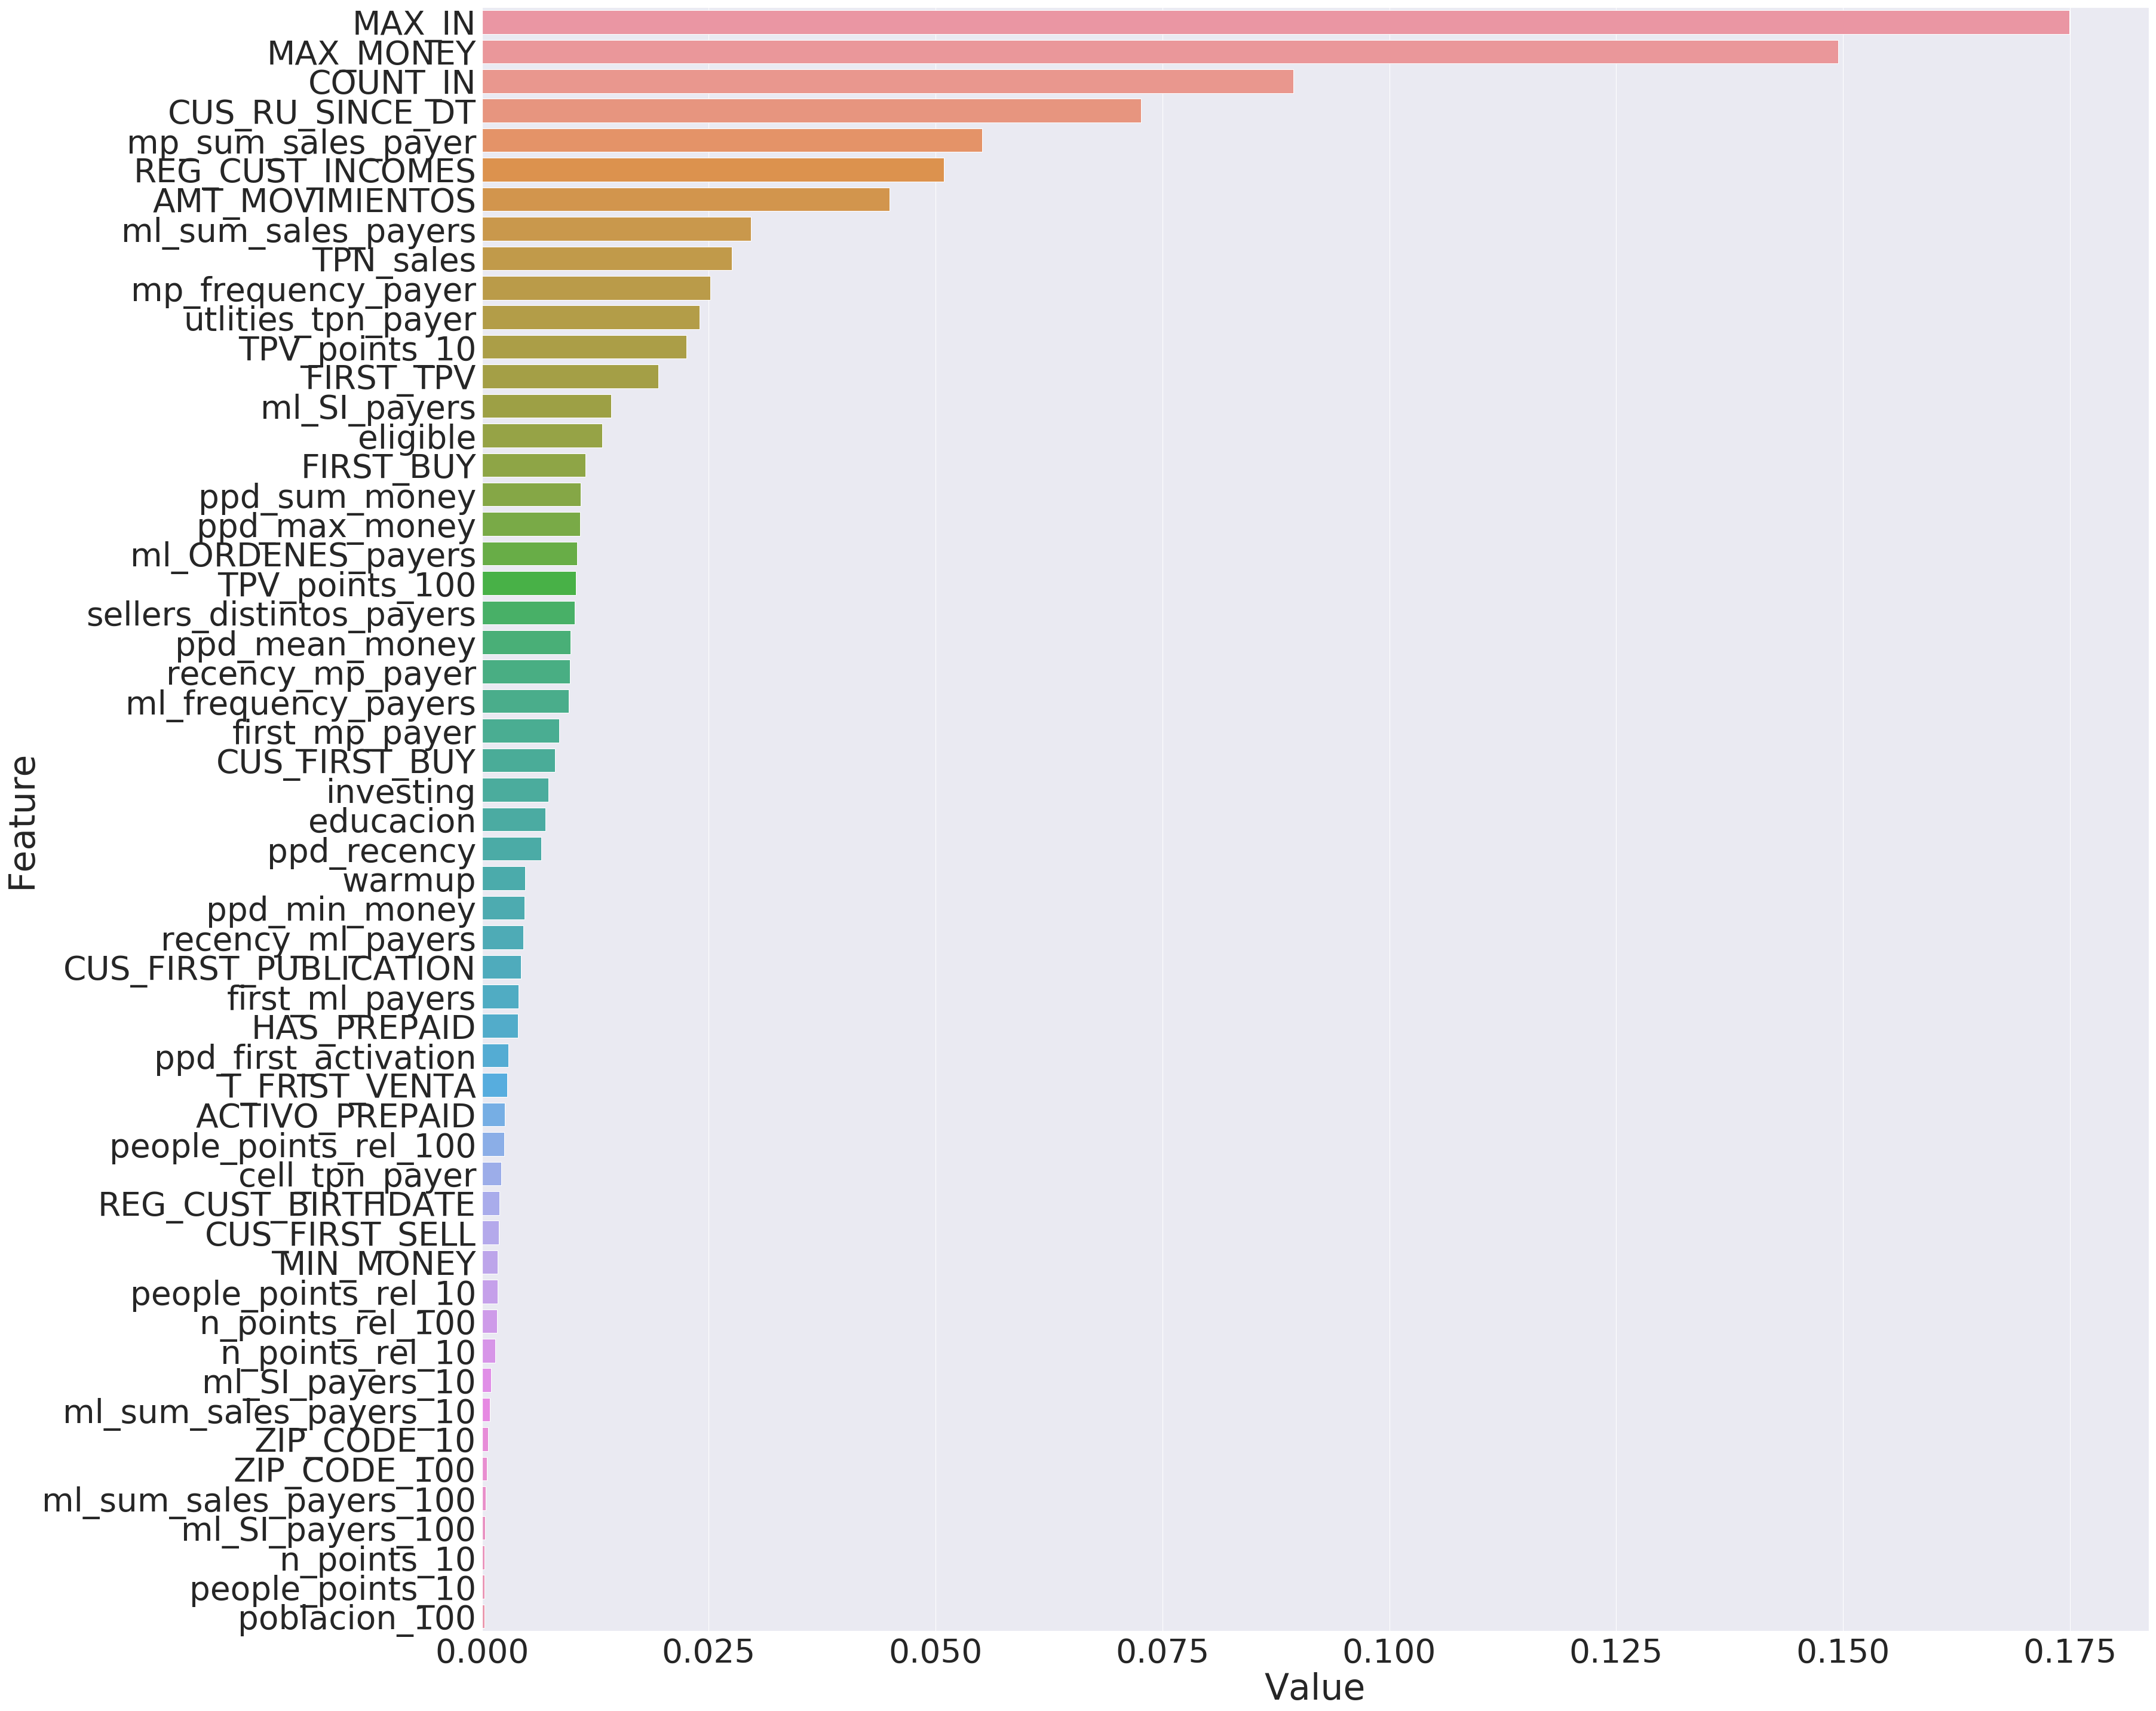

In [26]:
rf_random = RandomForestClassifier(**model.best_params_)
rf_random.fit(np.c_[X_train,np.random.randn(X_train.shape[0])],y_train)
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(list(zip(train_cols+["rand"], rf_random.feature_importances_)),columns=['Feature','Value'])

plt.figure(figsize=(50, 50))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:55])

In [27]:
feature_imp = pd.DataFrame(list(zip(train_cols, model.best_estimator_.feature_importances_)),columns=['Feature','Value'])
features_important = feature_imp.sort_values(by="Value",ascending = False).head(40).Feature.values

In [28]:
features_important

array(['MAX_IN', 'MAX_MONEY', 'CUS_RU_SINCE_DT', 'COUNT_IN',
       'REG_CUST_INCOMES', 'AMT_MOVIMIENTOS', 'mp_sum_sales_payer',
       'ml_sum_sales_payers', 'TPV_points_10', 'TPN_sales', 'eligible',
       'FIRST_TPV', 'TPV_points_100', 'FIRST_BUY', 'mp_frequency_payer',
       'ml_SI_payers', 'CUS_FIRST_BUY', 'utlities_tpn_payer',
       'ml_ORDENES_payers', 'recency_mp_payer', 'ml_frequency_payers',
       'sellers_distintos_payers', 'first_mp_payer', 'investing',
       'educacion', 'HAS_PREPAID', 'first_ml_payers', 'recency_ml_payers',
       'warmup', 'CUS_FIRST_PUBLICATION', 'ppd_max_money',
       'ppd_mean_money', 'ppd_sum_money', 'REG_CUST_BIRTHDATE',
       'people_points_rel_10', 'ppd_recency', 'people_points_rel_100',
       'ppd_min_money', 'n_points_rel_100', 'MIN_MONEY'], dtype=object)

## Me fijo que tan bien anda el modelo para hacer lookalike

In [33]:
from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])

Seeds: 33907 Others: 349331 Proof: 9692 Proof test: 4840 Others test: 38815
Train: 359023 Test: 43655


In [38]:
train["proba"] = model.best_estimator_.predict_proba(train[train_cols])[:,1]
print("MAP :", my_map(train["alto"],train["proba"]))

MAP : 0.03686410400354307


### Ahora con SVM one class

In [15]:
s3_path_in = s3_path+"Dataset_seeds/"   # Common path
summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_train_seeds.pkl')
summary_cal =summary_cal.assign(target = 1)

s3_path_in = s3_path+"Dataset_others/"   # Common path
summary_cal = summary_cal.append(util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_train_others.pkl').assign(target = np.nan),ignore_index=True)
summary_cal = summary_cal.drop_duplicates(subset= "cust")
summary_cal.target = summary_cal.target.fillna(-1)


In [ ]:
# Inviable
from sklearn.svm import OneClassSVM

stdc = StandardScaler()
stdc_trained = stdc.fit(summary_cal[train_cols])

X_train_ =  stdc_trained.transform(summary_cal[train_cols])
y_train_ = np.array(summary_cal["target"])

model = OneClassSVM( kernel='rbf', gamma=0.005,verbose = True)
model.fit(X_train_,y_train_)

[LibSVM]

## Ahora pruebo con KNN

In [185]:
# train_cols = ['MAX_IN', 'MAX_MONEY', 'CUS_RU_SINCE_DT', 'COUNT_IN',
#        'REG_CUST_INCOMES', 'AMT_MOVIMIENTOS', 'mp_sum_sales_payer',
#        'ml_sum_sales_payers', 'TPV_points_10', 'TPN_sales', 'eligible',
#        'FIRST_TPV', 'TPV_points_100', 'FIRST_BUY', 'mp_frequency_payer',
#        'ml_SI_payers', 'CUS_FIRST_BUY', 'utlities_tpn_payer',
#        'ml_ORDENES_payers', 'recency_mp_payer', 'ml_frequency_payers',
#        'sellers_distintos_payers', 'first_mp_payer', 'investing',
#        'educacion', 'HAS_PREPAID', 'first_ml_payers', 'recency_ml_payers',
#        'warmup', 'CUS_FIRST_PUBLICATION', 'ppd_max_money',
#        'ppd_mean_money', 'ppd_sum_money', 'REG_CUST_BIRTHDATE',
#        'people_points_rel_10', 'ppd_recency', 'people_points_rel_100',
#        'ppd_min_money', 'n_points_rel_100', 'MIN_MONEY']

train_cols = ['MAX_IN', 'MAX_MONEY', 'CUS_RU_SINCE_DT', 'COUNT_IN',
       'REG_CUST_INCOMES', 'AMT_MOVIMIENTOS', 'mp_sum_sales_payer',
       'ml_sum_sales_payers', 'TPV_points_10', 'TPN_sales', 'eligible',
       'FIRST_TPV', 'TPV_points_100']

In [40]:
from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])

Seeds: 33907 Others: 349331 Proof: 9692 Proof test: 4840 Others test: 38815
Train: 359023 Test: 43655


In [41]:
def train_SVD(params):    
    red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
    pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(**red_params))])
    pipe = pipe.fit(train_all[train_cols])

    X_train_seeds = pipe.transform(seeds[train_cols])
    X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))
    X_test = pipe.transform(test[train_cols])

    knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
    neigh = NearestNeighbors(n_jobs=1, **knn_params)
    neigh.fit(X_train_seeds)

    distances, indices = neigh.kneighbors(X_train)

    # Ordenando por frequencia con la que aparecen:
    knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
    # Calculating frequency for each instance in the KNN matrix
    freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
    freq_table = freq_table.sort_values(["freq"], ascending = [0])

    resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
    local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
    resu = my_map(local_train["alto"],local_train["freq"])
    print(params,"MAP:",resu)
    return resu

param_grid = {
            "red__n_components":list(range(len(train_cols)-10,len(train_cols),1)),
            "knn__n_neighbors":list(range(10,200,10)),
            "knn__metric":["cosine","l1","l2"]
}

l_params = list(ParameterSampler(param_grid, n_iter=cores,
                                    random_state=0))

p = Pool(cpu_count())
resultados = list(tqdm(p.imap(train_SVD,l_params), total=cores))
p.close()
p.join()

df_Resu_svd = pd.DataFrame(l_params)
df_Resu_svd["MAP"] = resultados

  0%|          | 0/39 [00:00<?, ?it/s]

{'knn__metric': 'l2', 'knn__n_neighbors': 10, 'red__n_components': 7} MAP: 0.28432862877231213
{'knn__metric': 'l2', 'knn__n_neighbors': 20, 'red__n_components': 6} MAP: 0.28639288226486725
{'knn__metric': 'l1', 'knn__n_neighbors': 70, 'red__n_components': 3} MAP: 0.28810483899958833
{'knn__metric': 'l1', 'knn__n_neighbors': 80, 'red__n_components': 4} MAP: 0.2865995530415819
{'knn__metric': 'l1', 'knn__n_neighbors': 130, 'red__n_components': 4} MAP: 0.28816405952833496
{'knn__metric': 'l1', 'knn__n_neighbors': 10, 'red__n_components': 9} MAP: 0.28431951486291923


  3%|▎         | 1/39 [01:21<51:51, 81.89s/it]

{'knn__metric': 'l2', 'knn__n_neighbors': 130, 'red__n_components': 5} MAP: 0.2876439379899939
{'knn__metric': 'l2', 'knn__n_neighbors': 160, 'red__n_components': 4} MAP: 0.2875848006630245
{'knn__metric': 'l2', 'knn__n_neighbors': 120, 'red__n_components': 5} MAP: 0.2878237916894825
{'knn__metric': 'l2', 'knn__n_neighbors': 40, 'red__n_components': 10} MAP: 0.2852542991041484
{'knn__metric': 'l1', 'knn__n_neighbors': 170, 'red__n_components': 4} MAP: 0.2876441429941301
{'knn__metric': 'l2', 'knn__n_neighbors': 60, 'red__n_components': 9} MAP: 0.2855318577593913
{'knn__metric': 'l1', 'knn__n_neighbors': 150, 'red__n_components': 5} MAP: 0.2880380293817205
{'knn__metric': 'l1', 'knn__n_neighbors': 180, 'red__n_components': 5} MAP: 0.2875501108186564
{'knn__metric': 'l1', 'knn__n_neighbors': 60, 'red__n_components': 8} MAP: 0.2852651425479216
{'knn__metric': 'l1', 'knn__n_neighbors': 150, 'red__n_components': 6} MAP: 0.2864633222175351
{'knn__metric': 'l1', 'knn__n_neighbors': 170, 'red_

  8%|▊         | 3/39 [07:06<1:05:24, 109.01s/it]

{'knn__metric': 'cosine', 'knn__n_neighbors': 170, 'red__n_components': 8} MAP: 0.28618443065083393


100%|██████████| 39/39 [07:09<00:00, 11.01s/it]


In [ ]:
def train_PCA(params):    
    red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
    pipe = Pipeline([('std', StandardScaler()), ('red', PCA(**red_params))])
    pipe = pipe.fit(train_all[train_cols])

    X_train_seeds = pipe.transform(seeds[train_cols])
    X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))
    X_test = pipe.transform(test[train_cols])

    knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
    neigh = NearestNeighbors(n_jobs=1, **knn_params)
    neigh.fit(X_train_seeds)

    distances, indices = neigh.kneighbors(X_train)

    # Ordenando por frequencia con la que aparecen:
    knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
    # Calculating frequency for each instance in the KNN matrix
    freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
    freq_table = freq_table.sort_values(["freq"], ascending = [0])

    resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
    local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
    resu = my_map(local_train["alto"],local_train["freq"])
    print(params,"MAP:",resu)
    return resu

param_grid = {
            "red__n_components":list(range(len(train_cols)-10,len(train_cols),1)),
#             "red__kernel":["linear","rbf"],
            "knn__n_neighbors":list(range(10,60,1)),
            "knn__metric":["cosine","l1","l2"]
}

l_params = list(ParameterSampler(param_grid, n_iter=cores,
                                    random_state=0))

p = Pool(cpu_count())
resultados = list(tqdm(p.imap(train_PCA,l_params), total=cores))
p.close()
p.join()

df_Resu_pca = pd.DataFrame(l_params)
df_Resu_pca["MAP"] = resultados

In [7]:
train_cols = ['MAX_IN', 'MAX_MONEY', 'CUS_RU_SINCE_DT', 'COUNT_IN',
       'REG_CUST_INCOMES', 'AMT_MOVIMIENTOS', 'mp_sum_sales_payer',
       'ml_sum_sales_payers', 'TPV_points_10', 'TPN_sales', 'eligible',
       'FIRST_TPV', 'TPV_points_100']

In [8]:
def train_SVD(params):    
    red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
    pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(**red_params))])
    pipe = pipe.fit(train_all[train_cols])

    X_train_seeds = pipe.transform(seeds[train_cols])
    X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))
    X_test = pipe.transform(test[train_cols])

    knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
    neigh = NearestNeighbors(n_jobs=1, **knn_params)
    neigh.fit(X_train_seeds)

    distances, indices = neigh.kneighbors(X_train)

    # Ordenando por frequencia con la que aparecen:
    knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
    # Calculating frequency for each instance in the KNN matrix
    freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
    freq_table = freq_table.sort_values(["freq"], ascending = [0])

    resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
    local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
    resu = my_map(local_train["alto"],local_train["freq"])
    print(params,"MAP:",resu)
    return resu

param_grid = {
            "red__n_components":list(range(len(train_cols)-10,len(train_cols),1)),
            "knn__n_neighbors":list(range(15,60,1)),
            "knn__metric":["cosine","l1","l2"]
}

l_params = list(ParameterSampler(param_grid, n_iter=cores,
                                    random_state=0))

p = Pool(cpu_count())
resultados = list(tqdm(p.imap(train_SVD,l_params), total=cores))
p.close()
p.join()

df_Resu_svd = pd.DataFrame(l_params)
df_Resu_svd["MAP"] = resultados

  0%|          | 0/39 [00:00<?, ?it/s]

{'red__n_components': 19, 'knn__n_neighbors': 19, 'knn__metric': 'cosine'} MAP: 0.2871046380465459
{'red__n_components': 21, 'knn__n_neighbors': 31, 'knn__metric': 'cosine'} MAP: 0.28826105622307324
{'red__n_components': 22, 'knn__n_neighbors': 34, 'knn__metric': 'cosine'} MAP: 0.2885771468687033
{'red__n_components': 24, 'knn__n_neighbors': 38, 'knn__metric': 'cosine'} MAP: 0.28878781114477936
{'red__n_components': 24, 'knn__n_neighbors': 36, 'knn__metric': 'cosine'} MAP: 0.2888001370120754
{'red__n_components': 21, 'knn__n_neighbors': 37, 'knn__metric': 'cosine'} MAP: 0.28846133715108296
{'red__n_components': 21, 'knn__n_neighbors': 32, 'knn__metric': 'cosine'} MAP: 0.2882994628096309
{'red__n_components': 20, 'knn__n_neighbors': 38, 'knn__metric': 'cosine'} MAP: 0.2883614916094641
{'red__n_components': 27, 'knn__n_neighbors': 15, 'knn__metric': 'cosine'} MAP: 0.2870733665211168
{'red__n_components': 20, 'knn__n_neighbors': 18, 'knn__metric': 'cosine'} MAP: 0.2874044506651762
{'red__

  3%|▎         | 1/39 [12:31<7:56:09, 751.82s/it]

{'red__n_components': 26, 'knn__n_neighbors': 35, 'knn__metric': 'l1'} MAP: 0.2887846447036749
{'red__n_components': 28, 'knn__n_neighbors': 29, 'knn__metric': 'l1'} MAP: 0.2888087717456285
{'red__n_components': 28, 'knn__n_neighbors': 31, 'knn__metric': 'l1'} MAP: 0.2888125562335153
{'red__n_components': 27, 'knn__n_neighbors': 36, 'knn__metric': 'l1'} MAP: 0.2888867831427486


100%|██████████| 39/39 [13:10<00:00, 20.26s/it]  


In [7]:
def train_PCA(params):    
    red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
    pipe = Pipeline([('std', StandardScaler()), ('red', PCA(**red_params))])
    pipe = pipe.fit(train_all[train_cols])

    X_train_seeds = pipe.transform(seeds[train_cols])
    X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))
    X_test = pipe.transform(test[train_cols])

    knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
    neigh = NearestNeighbors(n_jobs=1, **knn_params)
    neigh.fit(X_train_seeds)

    distances, indices = neigh.kneighbors(X_train)

    # Ordenando por frequencia con la que aparecen:
    knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
    # Calculating frequency for each instance in the KNN matrix
    freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
    freq_table = freq_table.sort_values(["freq"], ascending = [0])

    resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
    local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
    resu = my_map(local_train["alto"],local_train["freq"])
    print(params,"MAP:",resu)
    return resu

param_grid = {
            "red__n_components":list(range(len(train_cols)-10,len(train_cols),1)),
#             "red__kernel":["linear","rbf"],
            "knn__n_neighbors":list(range(10,60,1)),
            "knn__metric":["cosine","l1","l2"]
}

l_params = list(ParameterSampler(param_grid, n_iter=cores,
                                    random_state=0))

p = Pool(cpu_count())
resultados = list(tqdm(p.imap(train_PCA,l_params), total=cores))
p.close()
p.join()

df_Resu_pca = pd.DataFrame(l_params)
df_Resu_pca["MAP"] = resultados


  0%|          | 0/39 [00:00<?, ?it/s]

{'knn__metric': 'l2', 'knn__n_neighbors': 33, 'red__n_components': 4} MAP: 0.287117288848111
{'knn__metric': 'l2', 'knn__n_neighbors': 19, 'red__n_components': 5} MAP: 0.28566779317425395
{'knn__metric': 'l2', 'knn__n_neighbors': 22, 'red__n_components': 5} MAP: 0.2856934405824689
{'knn__metric': 'l1', 'knn__n_neighbors': 30, 'red__n_components': 4} MAP: 0.2872013204724042
{'knn__metric': 'l2', 'knn__n_neighbors': 28, 'red__n_components': 5} MAP: 0.2858732494845139
{'knn__metric': 'l2', 'knn__n_neighbors': 14, 'red__n_components': 6} MAP: 0.2862525440670089
{'knn__metric': 'l1', 'knn__n_neighbors': 15, 'red__n_components': 5} MAP: 0.2861322590843643
{'knn__metric': 'l1', 'knn__n_neighbors': 37, 'red__n_components': 4} MAP: 0.2867768416668161
{'knn__metric': 'l2', 'knn__n_neighbors': 19, 'red__n_components': 6} MAP: 0.2859221733668935
{'knn__metric': 'l2', 'knn__n_neighbors': 27, 'red__n_components': 6} MAP: 0.2857490809405752
{'knn__metric': 'l1', 'knn__n_neighbors': 16, 'red__n_compon


  3%|▎         | 1/39 [01:21<51:27, 81.24s/it]

{'knn__metric': 'l2', 'knn__n_neighbors': 37, 'red__n_components': 7} MAP: 0.2860012213504529
{'knn__metric': 'l1', 'knn__n_neighbors': 20, 'red__n_components': 7} MAP: 0.2860361405278952
{'knn__metric': 'l2', 'knn__n_neighbors': 35, 'red__n_components': 8} MAP: 0.2889379687634776
{'knn__metric': 'l2', 'knn__n_neighbors': 15, 'red__n_components': 10} MAP: 0.28772070257886795
{'knn__metric': 'l1', 'knn__n_neighbors': 39, 'red__n_components': 7} MAP: 0.28618409122183114
{'knn__metric': 'l2', 'knn__n_neighbors': 21, 'red__n_components': 11} MAP: 0.288305701100706
{'knn__metric': 'l2', 'knn__n_neighbors': 36, 'red__n_components': 10} MAP: 0.28856503235208325
{'knn__metric': 'l1', 'knn__n_neighbors': 14, 'red__n_components': 9} MAP: 0.28807142423110355
{'knn__metric': 'l2', 'knn__n_neighbors': 25, 'red__n_components': 13} MAP: 0.2884493157928485
{'knn__metric': 'l1', 'knn__n_neighbors': 20, 'red__n_components': 10} MAP: 0.2880337545414838
{'knn__metric': 'l1', 'knn__n_neighbors': 32, 'red__


  5%|▌         | 2/39 [04:47<1:13:14, 118.76s/it]

{'knn__metric': 'cosine', 'knn__n_neighbors': 20, 'red__n_components': 7} MAP: 0.28506408620082474
{'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'red__n_components': 8} MAP: 0.2869292152101817
{'knn__metric': 'cosine', 'knn__n_neighbors': 37, 'red__n_components': 6} MAP: 0.2854285514601491
{'knn__metric': 'cosine', 'knn__n_neighbors': 25, 'red__n_components': 12} MAP: 0.28706948656161246
{'knn__metric': 'l1', 'knn__n_neighbors': 36, 'red__n_components': 11} MAP: 0.28793208372822
{'knn__metric': 'l1', 'knn__n_neighbors': 25, 'red__n_components': 12} MAP: 0.28803013585182147
{'knn__metric': 'l1', 'knn__n_neighbors': 20, 'red__n_components': 13} MAP: 0.2876906124917747



  8%|▊         | 3/39 [05:12<54:22, 90.64s/it]   

{'knn__metric': 'l1', 'knn__n_neighbors': 18, 'red__n_components': 13} MAP: 0.2878930103286581
{'knn__metric': 'l1', 'knn__n_neighbors': 19, 'red__n_components': 13} MAP: 0.2877131883853865



 21%|██        | 8/39 [05:17<32:56, 63.76s/it]

{'knn__metric': 'l1', 'knn__n_neighbors': 34, 'red__n_components': 13} MAP: 0.2879108374202478



100%|██████████| 39/39 [05:27<00:00,  8.40s/it]


In [42]:
params = {'knn__metric': 'l2', 'knn__n_neighbors': 35, 'red__n_components': 8}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler()), ('red', PCA(**red_params))])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_test = pipe.transform(test[train_cols]); test["indices"] = list(range(test.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_test)

# Ordenando por frequencia con la que aparecen:
knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(test,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

Testing MAP: 0.14353781064772483


In [9]:
params = {'red__n_components': 25, 'knn__n_neighbors': 34, 'knn__metric': 'l2'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(**red_params))])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_test = pipe.transform(test[train_cols]); test["indices"] = list(range(test.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_test)

# Ordenando por frequencia con la que aparecen:
knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(test,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

Testing MAP: 0.1466768222838636


In [48]:
params = {'red__n_components': 25, 'knn__n_neighbors': 34, 'knn__metric': 'l2'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(**red_params))])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_train)

# Ordenando por frequencia con la que aparecen:
knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

Testing MAP: 0.289107816392657


In [52]:
from sklearn.metrics import precision_score,recall_score

p = [];r = [];frec = []

local_train = local_train.sort_values(by="freq",ascending = False)

for f in range(0,20000,20):
    local_train["pred"] = np.where(local_train.freq >= f,1,0)
    p.append(100*precision_score(local_train.alto.replace({-1:0}),local_train.pred))
    r.append(100*recall_score(local_train.alto.replace({-1:0}),local_train.pred))
    frec.append(f)

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


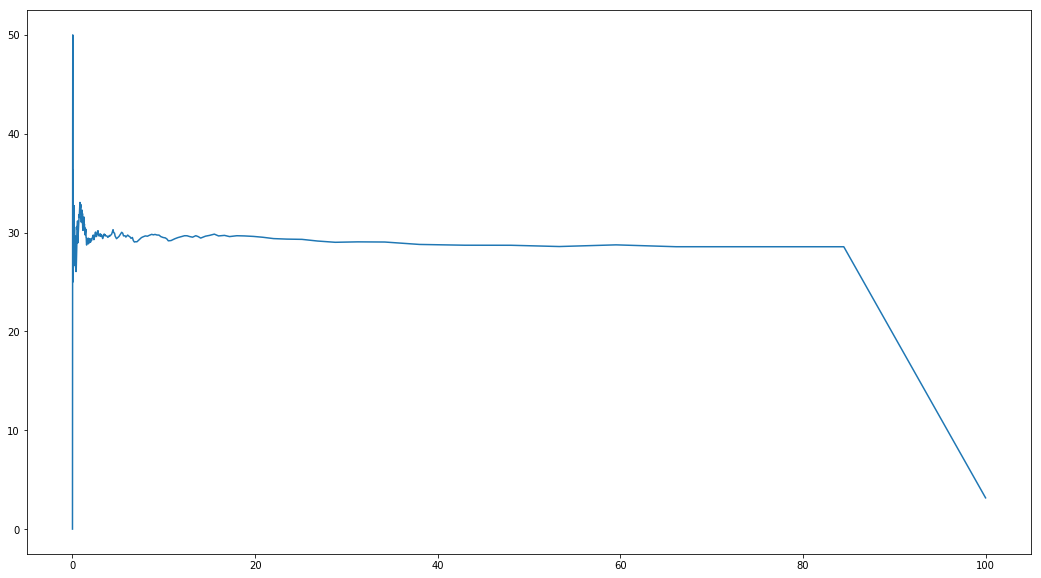

In [53]:
plt.figure(figsize=(18,10))
plt.plot(r,p)

(0.2, 0.4)

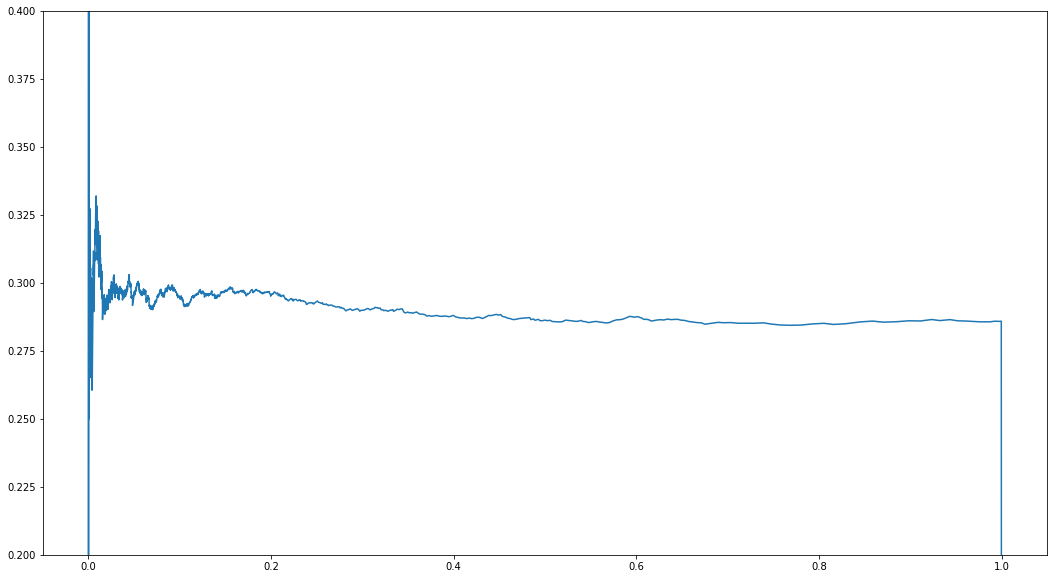

In [56]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(local_train["alto"],local_train["freq"])
plt.figure(figsize=(18,10))
plt.plot(recall,precision)
plt.ylim([0.2,0.4])

## Pruebo midiendo distancias a ver si mejora curva PR

In [184]:
from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])

Seeds: 33907 Others: 349331 Proof: 9692 Proof test: 4840 Others test: 38815
Train: 359023 Test: 43655


In [186]:
train_cols = ['MAX_IN', 'MAX_MONEY', 'CUS_RU_SINCE_DT', 'COUNT_IN',
       'REG_CUST_INCOMES', 'AMT_MOVIMIENTOS', 'mp_sum_sales_payer',
       'ml_sum_sales_payers', 'TPV_points_10', 'TPN_sales', 'eligible',
       'FIRST_TPV', 'TPV_points_100']

In [190]:
params = {'red__n_components': len(train_cols)-1, 'knn__n_neighbors': 10, 'knn__metric': 'cosine'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(**red_params))])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=-1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_train)
distances = np.array(distances)
distances = distances.mean(axis = 1).reshape(distances.shape[0],1)

# Ordenando por frequencia con la que aparecen:
# # Calculating frequency for each instance in the KNN matrix

train["freq"] = distances
resu = my_map(train["alto"],train["freq"],ascending=True)
print("Testing MAP:",resu) 

Testing MAP: 0.03343867978756178


(0.2, 0.4)

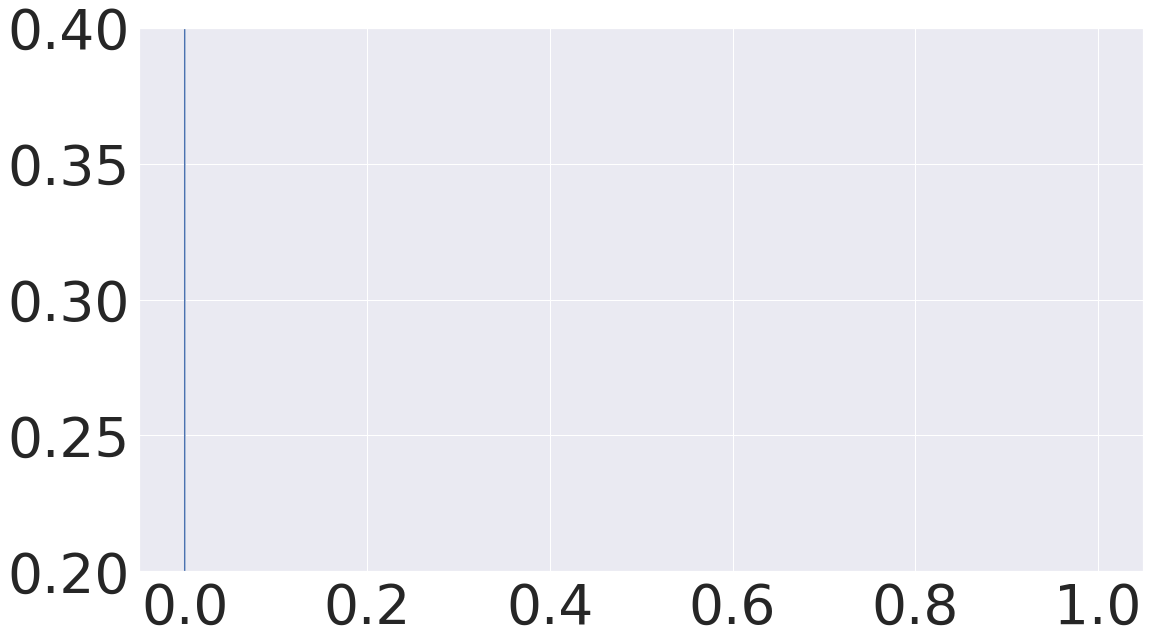

In [191]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(train["alto"],train["freq"])
plt.figure(figsize=(18,10))
plt.plot(recall,precision)
plt.ylim([0.2,0.4])

## Pruebo con LSH

In [49]:
from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])

Seeds: 33907 Others: 349331 Proof: 9692 Proof test: 4840 Others test: 38815
Train: 359023 Test: 43655


In [51]:
# ! pip install nearpy
import numpy
import scipy
import unittest
import nearpy.utils.utils
from nearpy import Engine
from nearpy.distances import CosineDistance
from nearpy.hashes import RandomBinaryProjections, RandomBinaryProjectionTree, HashPermutations, HashPermutationMapper

X_seeds = seeds[train_cols].values
# Dimension of feature space
DIM = len(train_cols)

# Create permutations meta-hash
permutations = HashPermutations('permut')

# Create binary hash as child hash
rbp_perm = RandomBinaryProjections('rbp_perm', 20)
rbp_conf = {'num_permutation':50,'beam_size':10,'num_neighbour':100}

# Add rbp as child hash of permutations hash
permutations.add_child_hash(rbp_perm, rbp_conf)

# Create engine 3
engine_perm = Engine(DIM, lshashes=[permutations], distance=CosineDistance())

# Create permutations meta-hash
permutations2 = HashPermutationMapper('permut2')

# Create binary hash as child hash
rbp_perm2 = RandomBinaryProjections('rbp_perm2', 12)

# Add rbp as child hash of permutations hash
permutations2.add_child_hash(rbp_perm2)

# Create engine 3
engine_perm2 = Engine(DIM, lshashes=[permutations2], distance=CosineDistance())


# First index some random vectors
matrix = numpy.zeros((X_seeds.shape[0],DIM))
for i in range(X_seeds.shape[0]):
    v = X_seeds[i,:]
    matrix[i, :] = nearpy.utils.utils.unitvec(X_seeds[i,:])
    engine_perm2.store_vector(v, i)



In [ ]:
indexes = []
for i in range(test.shape[0]):
    indexes.append(np.array(engine_perm2.neighbours(test[train_cols].values[i,:])))
    if(i%1000 == 0):
        print(i)
    
indexes = np.array(indexes)

In [92]:
def query(dfs):
    indexes = []
    for i in range(dfs.shape[0]):
        indexes.append(np.array(engine_perm2.neighbours(dfs[i,:])))
        if((i%1000 == 0) & (i > 0)):
            print(i)
    return indexes

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

l_dfs = []
inic = list(range(X_train.shape[0]))
X_train = np.array(test[train_cols])
for i in chunks(inic,len(inic)//(cpu_count()-1)):
    l_dfs.append(X_train[i[0]:i[-1],:])


p = Pool(cpu_count())
resultados = list(tqdm(p.imap(query,l_dfs), total=cpu_count()))
p.close()
p.join()

df_Resu_pca = pd.DataFrame(l_params)
df_Resu_pca["MAP"] = resultados




  0%|          | 0/40 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for axis 0 with size 1

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [177]:
inds = []
for a in resultados:
    for b in a:
        inds.append([np.mean(x[2]) for x in b])

In [172]:
test["indices"] = list(range(test.shape[0]))
knn_indices_pd = pd.DataFrame(np.array(pd.DataFrame(inds)).flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(test,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 


Testing MAP: 0.14164606581721226


In [183]:
# test["dist"] = inds
# my_map(test["alto"],test["inds"])
sum([x.shape[0] for x in l_dfs]), test.shape

(43615, (43655, 75))

# Con todas las categoiras

In [42]:
train_cols = ['educacion', 'REG_CUST_INCOMES', 'MAX_MONEY', 'REG_CUST_BIRTHDATE',
       'MAX_IN', 'COUNT_IN', 'mp_sum_sales_payer', 'AMT_MOVIMIENTOS',
       'FIRST_TPV', 'TPV_points_10', 'FIRST_BUY', 'CUS_FIRST_BUY',
       'ml_sum_sales_payers', 'MASCULINO', 'ml_SI_payers', 'TPN_sales',
       'eligible', 'ml_ORDENES_payers', 'utlities_tpn_payer',
       'mp_frequency_payer', 'sellers_distintos_payers', 'first_mp_payer',
       'ml_frequency_payers', 'TPV_points_100', 'FEMININO', 'HAS_PREPAID',
       'recency_mp_payer', 'ppd_first_activation', 'investing',
       'first_ml_payers', 'recency_ml_payers', 'ppd_max_money', 'warmup',
       'people_points_rel_100', 'ppd_recency', 'ppd_mean_money',
       'CUS_FIRST_PUBLICATION', 'ppd_sum_money', 'T_FRIST_VENTA',
       'people_points_rel_10']

from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])


Seeds: 33436 Others: 292758 Proof: 9558 Proof test: 4773 Others test: 32529
Train: 302316 Test: 37302


In [36]:
params = { 'knn__n_neighbors': 80, 'knn__metric': 'l2'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler())])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=-1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_train)
distances = np.array(distances)
distances = distances.mean(axis = 1).reshape(distances.shape[0],1)

knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

Testing MAP: 0.2880961988233036


In [43]:
params = { 'knn__n_neighbors': 200, 'knn__metric': 'l2'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler())])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=-1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_train)
distances = np.array(distances)
distances = distances.mean(axis = 1).reshape(distances.shape[0],1)

knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

Testing MAP: 0.28824007916175975


In [ ]:
params = { 'knn__n_neighbors': 200, 'knn__metric': 'l2'}
red_params = {x.split("__")[-1]:y for x,y in params.items() if("red__" in x)}
pipe = Pipeline([('std', StandardScaler())])
pipe = pipe.fit(train_all[train_cols])

X_train_seeds = pipe.transform(seeds[train_cols])
X_train = pipe.transform(train[train_cols]); train["indices"] = list(range(train.shape[0]))

knn_params = {x.split("__")[-1]:y for x,y in params.items() if("knn__" in x)}
neigh = NearestNeighbors(n_jobs=-1, **knn_params)
neigh.fit(X_train_seeds)

distances, indices = neigh.kneighbors(X_train)
distances = np.array(distances)
distances = distances.mean(axis = 1).reshape(distances.shape[0],1)

knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
local_train = pd.merge(train,resu,on="indices",how="left").fillna(0)
resu = my_map(local_train["alto"],local_train["freq"])
print("Testing MAP:",resu) 

In [50]:
local_train.sort_values(by="freq",ascending = False)[train_cols[0:20]].head()

,educacion,REG_CUST_INCOMES,MAX_MONEY,REG_CUST_BIRTHDATE,MAX_IN,COUNT_IN,mp_sum_sales_payer,AMT_MOVIMIENTOS,FIRST_TPV,TPV_points_10,FIRST_BUY,CUS_FIRST_BUY,ml_sum_sales_payers,MASCULINO,ml_SI_payers,TPN_sales,eligible,ml_ORDENES_payers,utlities_tpn_payer,mp_frequency_payer
24112,4.000000,1.000000,0.00,30.00000,0.00,0.0,0.000,0.0,0.0000,2324.799378,-99.0,159.0,64.49,0.0,2.0,0.0,0.0,2.0,0.0,0.0
24687,3.924532,2518.952552,0.00,33.31797,0.00,0.0,0.000,0.0,0.0000,1738.013264,-99.0,986.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33148,3.924532,2518.952552,0.00,33.31797,0.00,0.0,0.000,0.0,0.0000,1451.215382,-99.0,-99.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28083,3.924532,2001.000000,0.00,50.00000,0.00,0.0,0.000,0.0,0.0000,1838.772440,-99.0,613.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0
15892,3.924532,991.000000,268.83,20.00000,191.14,5.0,110.871,31.0,2.9821,2149.553766,113.0,638.0,35.81,1.0,1.0,13.0,0.0,1.0,2.0,12.0


## Voy a explorar un poco a ver si recortando mejora la cosa

In [3]:
from sklearn.pipeline import Pipeline
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"summary_cal.pkl")
summary_cal = summary_cal.loc[summary_cal.alto.isin([1,-1])]

seeds,proof = train_test_split(summary_cal.loc[summary_cal.alto == 1],test_size=0.3,random_state=0)
proof,test_proof = train_test_split(proof,test_size=0.333,random_state=0)

others,test_others = train_test_split(summary_cal.loc[summary_cal.alto == -1],test_size=0.1,random_state=0)

train_all = seeds.append(proof,ignore_index = True).append(others,ignore_index = True)
train = proof.append(others,ignore_index = True)
test = test_proof.append(test_others,ignore_index = True)

print("Seeds:",seeds.shape[0],"Others:",others.shape[0],"Proof:",proof.shape[0],"Proof test:",test_proof.shape[0],"Others test:",test_others.shape[0])
print("Train:",train.shape[0],"Test:",test.shape[0])

Seeds: 33907 Others: 349331 Proof: 9692 Proof test: 4840 Others test: 38815
Train: 359023 Test: 43655


In [9]:
full_seeds = summary_cal.loc[summary_cal.alto == 1]
full_seeds.columns

Index(['cust', 'FECHA_VENTA', 'alto', 'CUS_FIRST_BUY', 'CUS_FIRST_PUBLICATION',
       'CUS_FIRST_SELL', 'CUS_RU_SINCE_DT', 'GENDER', 'T_FRIST_VENTA',
       'ml_sum_sales_payers', 'ml_SI_payers', 'ml_ORDENES_payers',
       'recency_ml_payers', 'first_ml_payers', 'ml_frequency_payers',
       'sellers_distintos_payers', 'disabled', 'eligible', 'investing',
       'non_eligible', 'pending', 'warmup', 'AMT_MOVIMIENTOS', 'MAX_MONEY',
       'MIN_MONEY', 'MAX_IN', 'COUNT_IN', 'TPN_sales', 'mp_sum_sales_payer',
       'recency_mp_payer', 'first_mp_payer', 'mp_frequency_payer',
       'money_transf_tpn_payer', 'instore_tpn_payer', 'utlities_tpn_payer',
       'cell_tpn_payer', 'FIRST_BUY', 'FIRST_APP_BUY', 'FIRST_HAS_DISCOUNT',
       'FIRST_TPV', 'HAS_PREPAID', 'ppd_recency', 'ppd_sum_money',
       'ppd_mean_money', 'ppd_min_money', 'ppd_max_money',
       'ppd_first_activation', 'ACTIVO_PREPAID', 'REG_CUST_SCHOOL',
       'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'educacion', 'FEMININO',

In [23]:
full_seeds.ACTIVO_PREPAID.value_counts()

0.0    45748
1.0     2691
Name: ACTIVO_PREPAID, dtype: int64

In [11]:
full_seeds.loc[full_seeds.COUNT_IN > 0].shape[0]

6254

In [16]:
full_seeds.loc[full_seeds.ml_SI_payers > 6].shape

(3480, 74)

In [18]:
full_seeds.loc[full_seeds.COUNT_IN > 3].shape

(3286, 74)

In [22]:
conditions = (full_seeds.ACTIVO_PREPAID == 1) | (full_seeds.COUNT_IN > 0) | (full_seeds.ml_SI_payers > 6)
full_seeds.loc[conditions].shape

(8637, 74)

In [ ]:
demo = utils.read_csv_from_s3("s3://" + fda_path + s3_path+"Dataset_seeds"+"/Demo.csv",sep = "|",shape = print_shape)
demo.REG_CUST_PROFESSION.value_counts()

In [28]:
demo = utils.read_csv_from_s3("s3://"+fda_path+s3_path_in+"users_seeds.csv",sep = "|",shape = print_shape)
demo.shape

(89517, 2)

### Pruebo con svd a ver si mejora

array([[0, 3],
       [1, 3]])

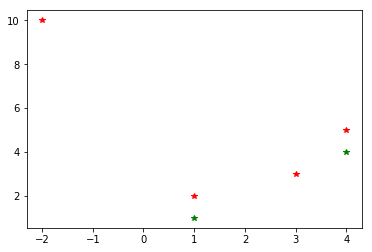

In [61]:
from sklearn.neighbors import NearestNeighbors

x = np.array([[1,2],[4,5],[-2,10],[3,3]])
plt.plot(x[:,0],x[:,1],'r*')

y = np.array([[1,1],[4,4]])
plt.plot(y[:,0],y[:,1],'g*')

neigh = NearestNeighbors(n_neighbors=2,n_jobs=-1,metric = 'l2')
neigh.fit(x)

distances, indices = neigh.kneighbors(y)
indices

In [17]:
train_cols = ['educacion', 'FEMININO', 'MASCULINO',
'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'CUS_FIRST_BUY',
'CUS_FIRST_PUBLICATION', 'T_FRIST_VENTA', 'bahia',
'minas gerais', 'other_state', 'rio de janeiro', 'sao paulo',
'ml_sum_sales_payers', 'ml_SI_payers', 'eligible', 'investing',
'warmup', 'mp_sum_sales_payer',
'FIRST_TPV','MAX_MONEY', 'MAX_IN']

In [34]:
from sklearn.decomposition import TruncatedSVD

# Pruebo con un venino, prueba simple
from sklearn.neighbors import NearestNeighbors

stdc = StandardScaler()
stdc_trained = stdc.fit(summary_cal[train_cols])


s3_path_in = s3_path+"Dataset_seeds/"   # Common path
summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_test_seeds.pkl')
summary_cal =summary_cal.assign(target = 1)

s3_path_in = s3_path+"Dataset_others/"   # Common path
summary_cal = summary_cal.append(util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_test_others.pkl').assign(target = np.nan),ignore_index=True)
summary_cal = summary_cal.append(util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_train_others.pkl').assign(target = np.nan),ignore_index=True)

summary_cal = summary_cal.drop_duplicates(subset= "cust")
summary_cal.target = summary_cal.target.fillna(-1)
summary_cal["indices"] = list(range(summary_cal.shape[0]))
print(summary_cal.shape[0])

X_test_ =  stdc_trained.transform(summary_cal[train_cols])
X_test_ = TruncatedSVD(n_components=X_test_.shape[1]-3).fit_transform(X_test_)

neigh = NearestNeighbors(n_neighbors=20,n_jobs=-1,metric = 'cosine')
neigh.fit(X_test_)

distances, indices = neigh.kneighbors(X_test_)

# Ordenando por frequencia con la que aparecen:
knn_indices_pd = pd.DataFrame(indices.flatten(),columns=["indices"])
# Calculating frequency for each instance in the KNN matrix
freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
freq_table = freq_table.sort_values(["freq"], ascending = [0])

resu = pd.DataFrame([]); resu["indices"] = list(freq_table.index); resu["freq"] = list(freq_table.freq)
summary_cal = pd.merge(summary_cal,resu,on="indices",how="left").fillna(0)
print("Score MAP:",my_map(summary_cal["target"],summary_cal["freq"]))



154030
Score MAP: 0.16218923351309983


In [16]:
summary_cal.columns

Index(['cust', 'FECHA_VENTA', 'educacion', 'FEMININO', 'MASCULINO',
       'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'CUS_FIRST_BUY',
       'CUS_FIRST_PUBLICATION', 'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'bahia',
       'minas gerais', 'other_state', 'rio de janeiro', 'sao paulo',
       'ml_sum_sales_payers', 'ml_SI_payers', 'ml_ORDENES_payers',
       'recency_ml_payers', 'first_ml_payers', 'ml_frequency_payers',
       'disabled', 'eligible', 'investing', 'non_eligible', 'pending',
       'warmup', 'TPN_sales', 'mp_sum_sales_payer', 'recency_mp_payer',
       'first_mp_payer', 'mp_frequency_payer', 'money_transf_tpn_payer',
       'instore_tpn_payer', 'utlities_tpn_payer', 'cell_tpn_payer',
       'FIRST_BUY', 'FIRST_APP_BUY', 'FIRST_HAS_DISCOUNT', 'FIRST_TPV',
       'AMT_MOVIMIENTOS', 'MAX_MONEY', 'MIN_MONEY', 'MAX_IN', 'COUNT_IN',
       'target', 'indices'],
      dtype='object')

In [10]:
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 38.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
from sklearn.decomposition import NMF,TruncatedSVD

for i in range()
NMF.fit(n_componentsint = X_train_.shape[1]-i)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

EOFError: EOF when reading a line

In [ ]:
# Initiating nearest neighbor search
    neighbors = NearestNeighbors(n_neighbors = num_neighbours,algorithm = tree_type).fit(knn_test)
    
    # Generating indices and distances for K Nearest Neighbours
    knn_distances,knn_indices = neighbors.kneighbors(knn_train)
    
    knn_indices_pd = pd.DataFrame(knn_indices.flatten(),columns=["indices"])

    # Calculating frequency for each instance in the KNN matrix
    freq_table = pd.crosstab(index = knn_indices_pd["indices"],columns = "freq")
    
    freq_table = freq_table.sort(["freq"], ascending = [0])
    
    # Selecting instances from test set with frequency greater than cutoff
    selected_lookalike_indices = freq_table.head(num_indices).index.tolist()
    
    # Subsetting the test set for data on the selected instances
    selected_lookalikes = test_df[test_df['indices'].isin(selected_lookalike_indices)]
    
    positive_lookalikes = selected_lookalikes[selected_lookalikes['label'] == '1']

    all_positives = test_df[test_df['label'] == '1']
    
    # Calculating the number of instances for each set
    num_positive_lookalikes = (float)(len(positive_lookalikes))
    num_all_positives = (float)(len(all_positives))
    num_selected_lookalikes = (float)(len(selected_lookalike_indices))
    num_test_instances = (float)(len(test_df))
    
    # Calculating recall and population shared
    # Ratio of individuals labeled positive by the algorithm to the actual number of positivies
    recall = num_positive_lookalikes/num_all_positives

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.54268


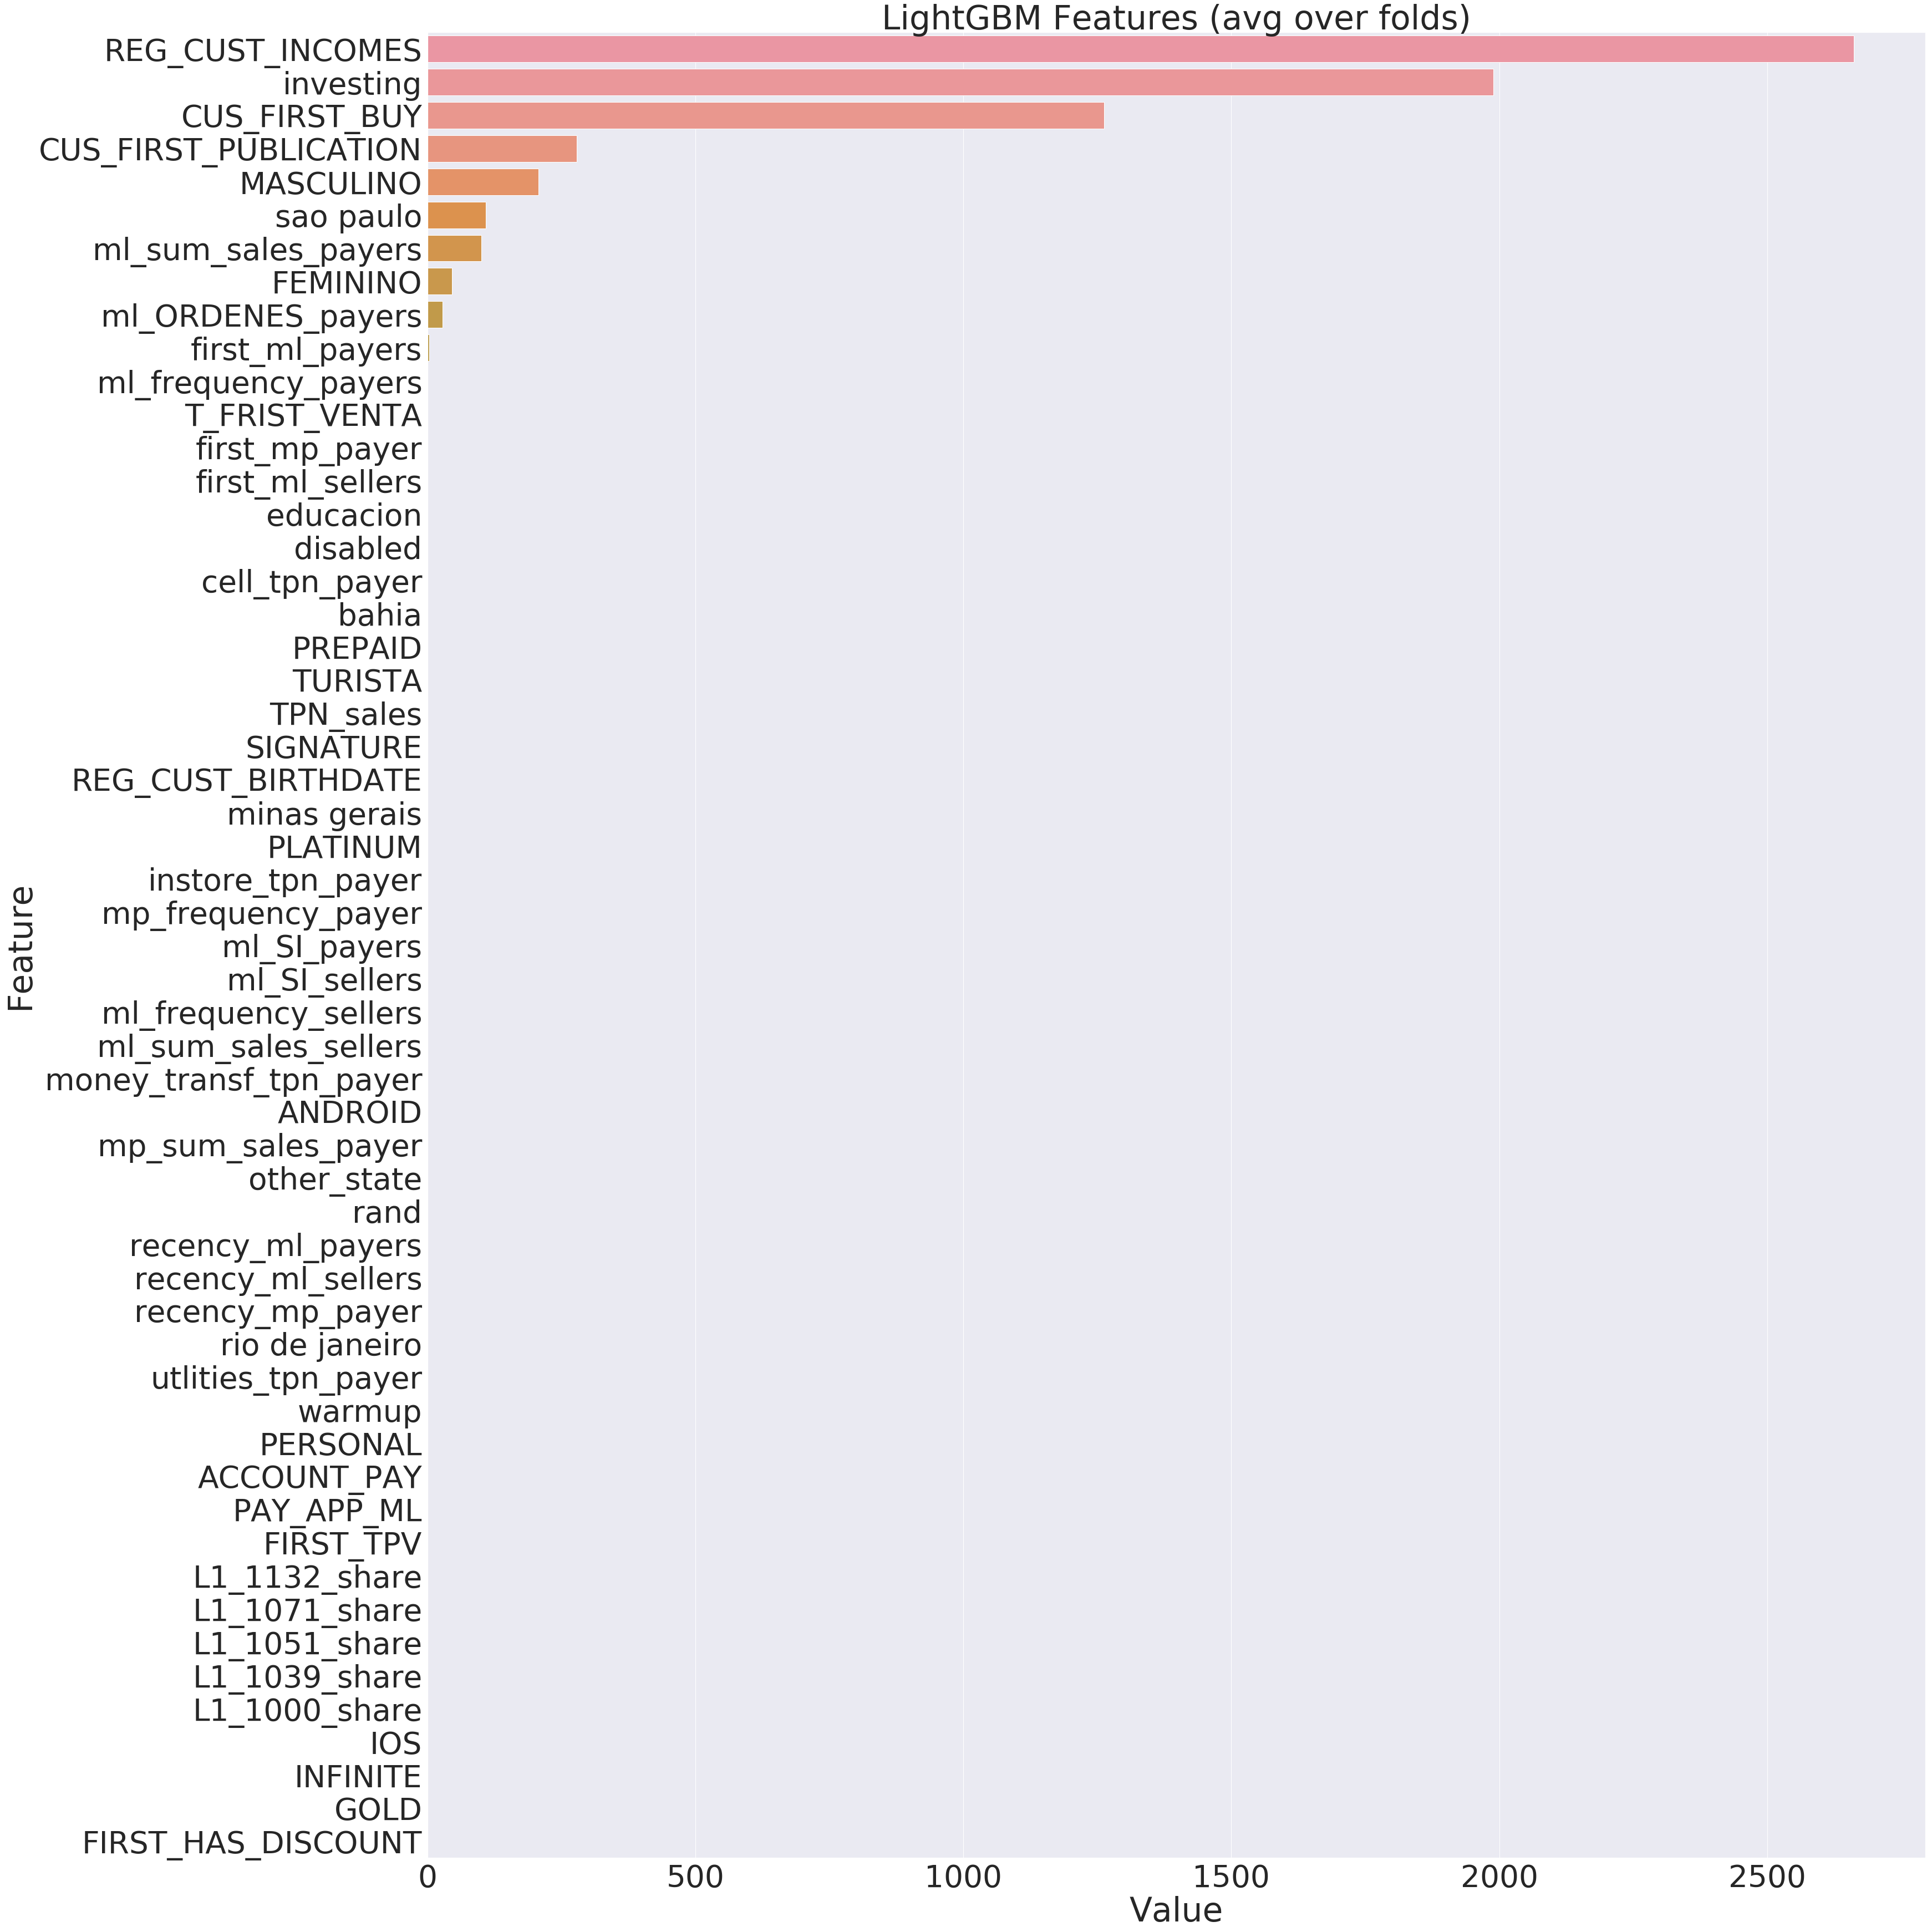

<Figure size 432x288 with 0 Axes>

In [38]:


print("target Rate:\n",summary_cal.target.value_counts()/summary_cal.shape[0]) # Me fijo cuantos puedo agarrar
proporcion = summary_cal.target.value_counts()[1]/summary_cal.shape[0]  # Porpocion que churnea

# Preproceso los datos
train, valid= train_test_split(summary_cal,test_size=0.15,random_state=0,stratify=summary_cal.target)
train, test= train_test_split(train,test_size=0.15,random_state=0,stratify=train.target)

stdc = StandardScaler()
stdc_trained = stdc.fit(train[train_cols])

X_train_ =  stdc_trained.transform(train[train_cols])
X_valid_ =  stdc_trained.transform(valid[train_cols])
X_test =  stdc_trained.transform(test[train_cols])

y_train_ =  np.array(train.target)
y_valid_ =  np.array(valid.target)
y_test =  np.array(test.target)  

# Entreno

basic_params = {
           "objective" :'binary',
           'boosting': "gbdt",
           'eval_metric':'binnary_error',
           'min_split_gain': 0,
           'subsample_freq': 3,
           'subsample_for_bin': 50000,
           'n_estimators': 4000,
            'n_jobs': cores,
           'verbose':-1,
           'random_state': 45
        }

resu = train_combinations(X_train_,X_valid_,y_train_,y_valid_,foo_evaluation_classifier,foo_predict_classifier,foo_model_classifier,basic_params)
best_model =  simple_fit(resu["params"].values[0],X_train_,y_train_,X_valid_,y_valid_,foo_model_classifier,basic_params)

error = foo_evaluation_classifier(y_test,foo_predict_classifier(best_model,X_test))
print("Error:",error)

p_errors = pd.DataFrame([{"error":error}])

picture(summary_cal,best_model.get_params(),stdc_trained,"target",foo_model_classifier)

# # Busco el treshold optimo
# from sklearn.metrics import precision_score

# test["churn_proba"] = np.array(best_model.predict_proba(X_test)[:,1])

# l_ = []
# for t in np.arange(0.001,0.99,0.01):
#     l_.append({"tresh":t,"precision":precision_score(test.churn,np.where(test.churn_proba >= t,1,0)),
#           "cantidad":test.loc[test.churn_proba >= t].shape[0]/test.shape[0]})

# df_tresh = pd.DataFrame(l_)

# if(df_tresh.loc[(df_tresh.cantidad > proporcion/2) & (df_tresh.precision > 0.6)].shape[0] == 0):
#     print("Modelo obsoleto!")
# else:
#     max_p = df_tresh.loc[(df_tresh.cantidad >= proporcion/2) ].precision.max()
#     tresh = df_tresh.loc[df_tresh.precision == max_p].tresh.values[0]
#     print("Treshold elegido:",tresh,"Precision:",df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
#           "Porcentaje alcanzado:",df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0])

# # Guado resultados!
# with open('model.pkl', 'wb') as fout:
#     pickle.dump(best_model, fout)
# my_upload_file("model.pkl","s3://"+fda_path+ s3_path_out_churn + "model.pkl")

# joblib.dump(stdc_trained,"std.sav")
# my_upload_file("std.sav", "s3://"+fda_path+ s3_path_out_churn+"std.sav")

# my_upload_file("lgbmImportance.png", "s3://"+fda_path + s3_path_out_churn+"lgbmImportance.png")

# util._write_dataframe_to_csv_on_s3(p_errors,"s3://"+fda_path+s3_path_out_churn + "errores_train.csv")

# # Aplico
# summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_churn+"summary_apply.pkl")
# summary_cal = summary_cal.loc[summary_cal.freq_q_past >= 4]

# my_download_file("s3://"+fda_path+ s3_path_out_churn+"model.pkl","model.pkl")
# my_download_file("s3://"+fda_path+ s3_path_out_churn+"std.sav","std.sav")

# stdc_trained = joblib.load("std.sav")
# X = stdc_trained.transform(summary_cal[train_cols])

# model = pickle.load(open("model.pkl", 'rb'))
# summary_cal["churn_proba"] = np.array(foo_predict_classifier(model,X))
# summary_cal["churn_tresh"] = 0
# summary_cal.loc[summary_cal.churn_proba >= tresh,"churn_tresh"] = 1

# # Guardo la data
# summary_cal = summary_cal[["cust","churn_proba","churn_tresh"]]
# summary_cal.columns = ["CUS_CUST_ID","CHURN_PROBA","CHURN_TRESH"]
# summary_cal.to_pickle("cal.pkl")
# my_upload_file("cal.pkl", "s3://"+fda_path+s3_path_out_churn+"churn_resu.pkl")

# return {"modelo":"churn","tresh":tresh,"tipo_error":"precision","error":df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
#           "personas":df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0]}

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.533289
Error: 0.3333816685561046
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.530749


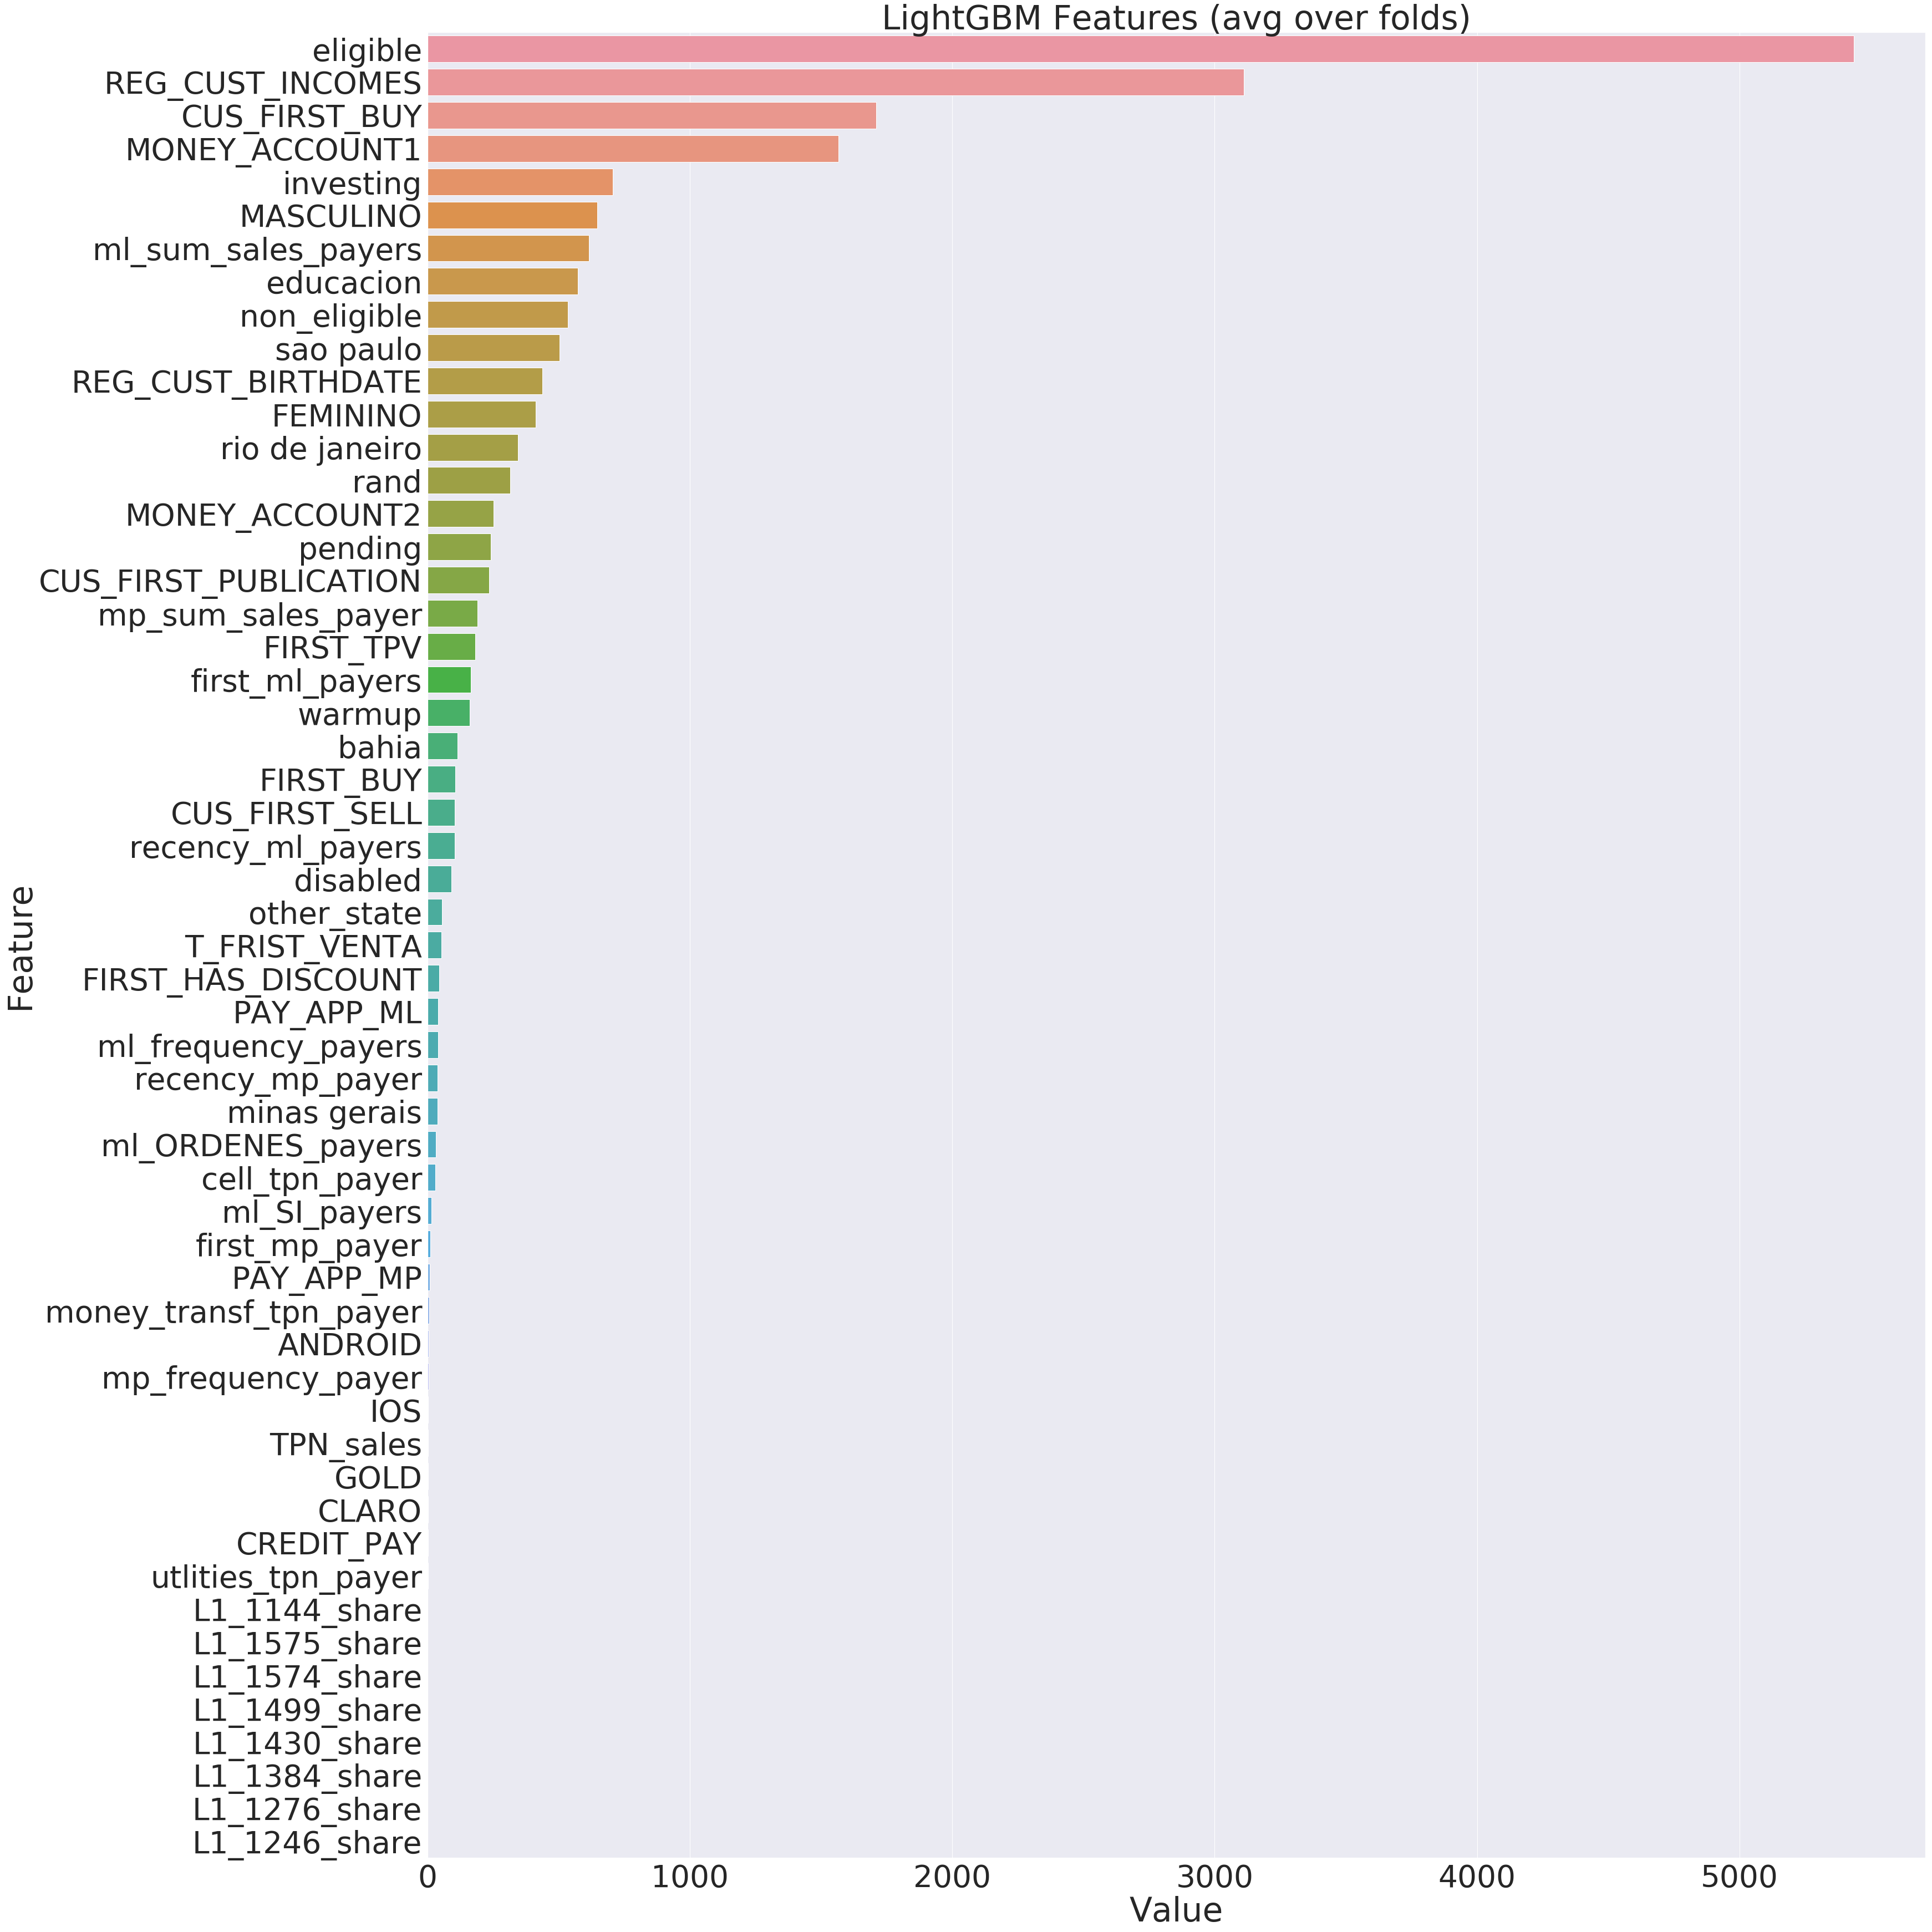

<Figure size 432x288 with 0 Axes>

In [33]:
best_model =  simple_fit(resu["params"].values[0],X_train_,y_train_,X_valid_,y_valid_,foo_model_classifier,basic_params)

error = foo_evaluation_classifier(y_test,foo_predict_classifier(best_model,X_test))
print("Error:",error)

p_errors = pd.DataFrame([{"error":error}])

picture(summary_cal,best_model.get_params(),stdc_trained,"target",foo_model_classifier)


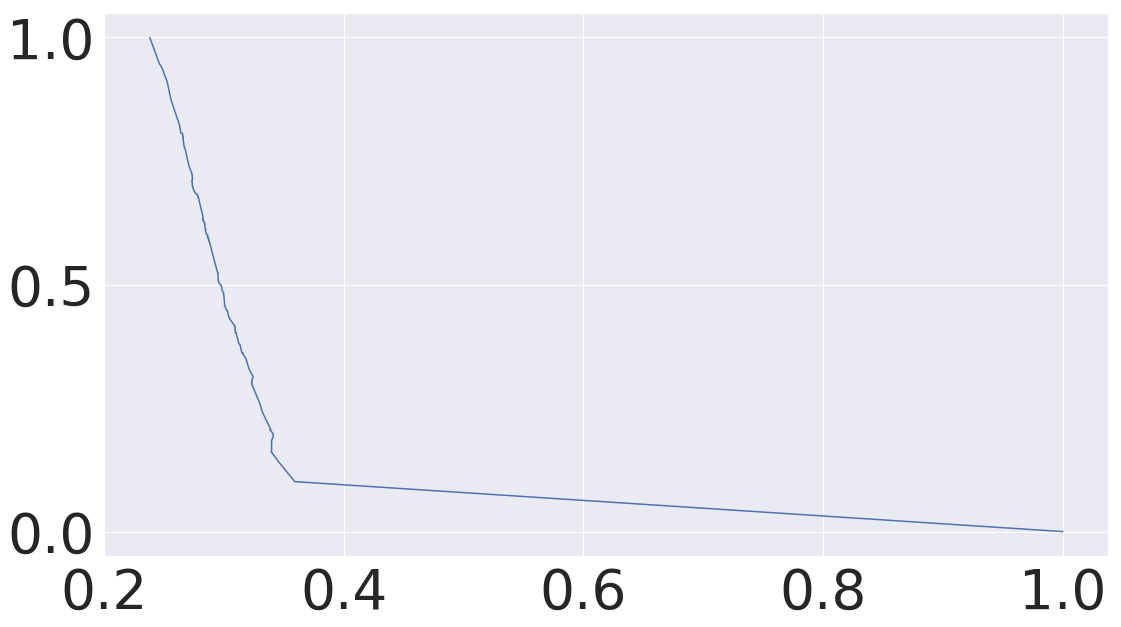

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
precision, recall, thresholds = precision_recall_curve(y_test,foo_predict_classifier(best_model,X_test))
plt.plot(precision,recall)

In [45]:
print("target Rate:\n",summary_cal.target.value_counts())

target Rate:
 0    133891
1     41884
Name: target, dtype: int64


In [26]:
# Levanto la data
def train_churn():
    summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_churn+"summary_train.pkl")
    summary_cal = summary_cal.loc[summary_cal.freq_q_past >= 4]
    comparacion1 = (summary_cal["frequency_eval"] < (summary_cal["freq_q_past"]/2)) & (summary_cal.freq_q_past >= 6)
    comparacion2 = ((summary_cal.freq_q_past < 6) & (summary_cal.frequency_eval == 0))
    summary_cal["churn"] = np.where(comparacion1 | comparacion2 ,1,0)

    print("Churn Rate:\n",summary_cal.churn.value_counts()/summary_cal.shape[0]) # Me fijo cuantos puedo agarrar
    proporcion = summary_cal.churn.value_counts()[1]/summary_cal.shape[0]  # Porpocion que churnea

    # Preproceso los datos
    train, valid= train_test_split(summary_cal,test_size=0.15,random_state=0,stratify=summary_cal.churn)
    train, test= train_test_split(train,test_size=0.15,random_state=0,stratify=train.churn)

    stdc = StandardScaler()
    stdc_trained = stdc.fit(train[train_cols])

    X_train_ =  stdc_trained.transform(train[train_cols])
    X_valid_ =  stdc_trained.transform(valid[train_cols])
    X_test =  stdc_trained.transform(test[train_cols])

    y_train_ =  np.array(train.churn)
    y_valid_ =  np.array(valid.churn)
    y_test =  np.array(test.churn)  

    # Entreno
    
    basic_params = {
               "objective" :'binary',
               'boosting': "gbdt",
               'eval_metric':'binnary_error',
               'min_split_gain': 0,
               'subsample_freq': 3,
               'subsample_for_bin': 50000,
               'n_estimators': 4000,
                'n_jobs': cores,
               'verbose':-1,
               'random_state': 45
            }
    
    resu = train_combinations(X_train_,X_valid_,y_train_,y_valid_,foo_evaluation_classifier,foo_predict_classifier,foo_model_classifier,basic_params)
    best_model =  simple_fit(resu["params"].values[0],X_train_,y_train_,X_valid_,y_valid_,foo_model_classifier,basic_params)

    error = foo_evaluation_classifier(y_test,foo_predict_classifier(best_model,X_test))
    print("Error:",error)

    p_errors = pd.DataFrame([{"error":error}])

    picture(summary_cal,best_model.get_params(),stdc_trained,"churn",foo_model_classifier)

    # Busco el treshold optimo
    from sklearn.metrics import precision_score

    test["churn_proba"] = np.array(best_model.predict_proba(X_test)[:,1])

    l_ = []
    for t in np.arange(0.001,0.99,0.01):
        l_.append({"tresh":t,"precision":precision_score(test.churn,np.where(test.churn_proba >= t,1,0)),
              "cantidad":test.loc[test.churn_proba >= t].shape[0]/test.shape[0]})

    df_tresh = pd.DataFrame(l_)

    if(df_tresh.loc[(df_tresh.cantidad > proporcion/2) & (df_tresh.precision > 0.6)].shape[0] == 0):
        print("Modelo obsoleto!")
    else:
        max_p = df_tresh.loc[(df_tresh.cantidad >= proporcion/2) ].precision.max()
        tresh = df_tresh.loc[df_tresh.precision == max_p].tresh.values[0]
        print("Treshold elegido:",tresh,"Precision:",df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
              "Porcentaje alcanzado:",df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0])

    # Guado resultados!
    with open('model.pkl', 'wb') as fout:
        pickle.dump(best_model, fout)
    my_upload_file("model.pkl","s3://"+fda_path+ s3_path_out_churn + "model.pkl")
    
    joblib.dump(stdc_trained,"std.sav")
    my_upload_file("std.sav", "s3://"+fda_path+ s3_path_out_churn+"std.sav")

    my_upload_file("lgbmImportance.png", "s3://"+fda_path + s3_path_out_churn+"lgbmImportance.png")
    
    util._write_dataframe_to_csv_on_s3(p_errors,"s3://"+fda_path+s3_path_out_churn + "errores_train.csv")

    # Aplico
    summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_churn+"summary_apply.pkl")
    summary_cal = summary_cal.loc[summary_cal.freq_q_past >= 4]

    my_download_file("s3://"+fda_path+ s3_path_out_churn+"model.pkl","model.pkl")
    my_download_file("s3://"+fda_path+ s3_path_out_churn+"std.sav","std.sav")

    stdc_trained = joblib.load("std.sav")
    X = stdc_trained.transform(summary_cal[train_cols])

    model = pickle.load(open("model.pkl", 'rb'))
    summary_cal["churn_proba"] = np.array(foo_predict_classifier(model,X))
    summary_cal["churn_tresh"] = 0
    summary_cal.loc[summary_cal.churn_proba >= tresh,"churn_tresh"] = 1

    # Guardo la data
    summary_cal = summary_cal[["cust","churn_proba","churn_tresh"]]
    summary_cal.columns = ["CUS_CUST_ID","CHURN_PROBA","CHURN_TRESH"]
    summary_cal.to_pickle("cal.pkl")
    my_upload_file("cal.pkl", "s3://"+fda_path+s3_path_out_churn+"churn_resu.pkl")
    
    return {"modelo":"churn","tresh":tresh,"tipo_error":"precision","error":df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
              "personas":df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0]}

In [31]:
def train_up():
    # Levanto los datos
    summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_churn+"summary_train.pkl")
    summary_cal = summary_cal.loc[summary_cal["T"] <= 60]
    comparacion1 = (summary_cal["frequency_eval"] >= (2*summary_cal["freq_q_past"])) & (summary_cal.freq_q_past >= 4)
    comparacion2 = ((summary_cal.freq_q_past < 4) & (summary_cal.frequency_eval >= 8))
    summary_cal["UP"] = np.where(comparacion1 | comparacion2 ,1,0)

    print("Up Rate:\n",summary_cal.UP.value_counts()/summary_cal.shape[0]) # Me fijo cuantos puedo agarrar
    
    # Preproceso los datos
    proporcion = summary_cal.UP.value_counts()[1]/summary_cal.shape[0]  # Porpocion que churnea

    train, valid= train_test_split(summary_cal,test_size=0.15,random_state=0,stratify=summary_cal.UP)
    train, test= train_test_split(train,test_size=0.15,random_state=0,stratify=train.UP)
    sample_train, _= train_test_split(train,test_size=0.5,random_state=0,stratify=train.UP)

    basic_params = {
                   "objective" :'binary',
                   'boosting': "gbdt",
                   'eval_metric':'binnary_error',
#                     'scale_pos_weight': summary_cal.value_counts[0]/summary_cal.value_counts[1], # desbalanceo
                   'min_split_gain': 0,
                   'subsample_freq': 3,
                   'subsample_for_bin': 50000,
                   'n_estimators': 4000,
                    'n_jobs': cores,
                   'verbose':-1,
                   'random_state': 45
                }

    stdc = StandardScaler()
    stdc_trained = stdc.fit(train[train_cols])  # entreno el normalizador con toda la data porque es rapidisimo ;)

    X_train_ =  stdc_trained.transform(sample_train[train_cols])
    X_valid_ =  stdc_trained.transform(valid[train_cols])
    X_test =  stdc_trained.transform(test[train_cols])

    y_train_ =  np.array(sample_train.UP)
    y_valid_ =  np.array(valid.UP)
    y_test =  np.array(test.UP)  

    # Entreno
    resu = train_combinations(X_train_,X_valid_,y_train_,y_valid_,foo_evaluation_classifier,foo_predict_classifier,foo_model_classifier,basic_params)
    X_train_ =  stdc_trained.transform(train[train_cols]) # Reentreno con toda la data
    y_train_ =  np.array(train.UP)
    best_model =  simple_fit(resu["params"].values[0],X_train_,y_train_,X_valid_,y_valid_,foo_model_classifier,basic_params)

    error = foo_evaluation_classifier(y_test,foo_predict_classifier(best_model,X_test))
    print("Error:",error)

    p_errors = pd.DataFrame([{"error":error}])

    picture(summary_cal,best_model.get_params(),stdc_trained,"UP",foo_model_classifier)

    # Busco el treshold optimo
    from sklearn.metrics import precision_score

    test["up_proba"] = np.array(best_model.predict_proba(X_test)[:,1])

    l_ = []
    for t in np.arange(0.001,0.99,0.01):
        l_.append({"tresh":t,"precision":precision_score(test.UP,np.where(test.up_proba >= t,1,0)),
              "cantidad":test.loc[test.up_proba >= t].shape[0]/test.shape[0]})

    df_tresh = pd.DataFrame(l_)

    if(df_tresh.loc[(df_tresh.cantidad > proporcion/2) & (df_tresh.precision > 0.6)].shape[0] == 0):
        print("Modelo obsoleto!")
    else:
        max_p = df_tresh.loc[(df_tresh.cantidad >= proporcion/2)].precision.max()
        tresh = df_tresh.loc[df_tresh.precision == max_p].tresh.values[0]
        print("Treshold elegido:",tresh,"Precision:",df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
              "Porcentaje alcanzado:",df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0])

    # Guado resultados!
    with open('model.pkl', 'wb') as fout:
        pickle.dump(best_model, fout)

    my_upload_file("model.pkl", "s3://"+fda_path + s3_path_out_up + "model.pkl")
    
    joblib.dump(stdc_trained,"std.sav")
    my_upload_file("std.sav", "s3://"+fda_path + s3_path_out_up+"std.sav")

    my_upload_file("lgbmImportance.png", "s3://"+fda_path + s3_path_out_up+"lgbmImportance.png")
    
    util._write_dataframe_to_csv_on_s3(p_errors,"s3://"+fda_path+s3_path_out_up + "errores_train.csv")

    # Aplico
    summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_churn+"summary_apply.pkl")
    summary_cal = summary_cal.loc[summary_cal["T"] < 60]

    my_download_file("s3://"+fda_path +s3_path_out_up+"model.pkl","model.pkl")
    my_download_file("s3://"+fda_path+ s3_path_out_up+"std.sav","std.sav")

    stdc_trained = joblib.load("std.sav")
    X = stdc_trained.transform(summary_cal[train_cols])

    model = pickle.load(open("model.pkl", 'rb'))
    summary_cal["up_proba"] = np.array(foo_predict_classifier(model,X))
    summary_cal["up_tresh"] = 0
    summary_cal.loc[summary_cal.up_proba >= tresh,"up_tresh"] = 1

    # Guardo la data
    summary_cal = summary_cal[["cust","up_proba","up_tresh"]]
    summary_cal.columns = ["CUS_CUST_ID","UP_PROBA","UP_TRESH"]
    summary_cal.to_pickle("cal.pkl")
    my_upload_file("cal.pkl", "s3://"+fda_path + s3_path_out_up+"up_resu.pkl")
    
    return {"modelo":"UP","tresh":tresh,"tipo_error":"precision","error":df_tresh.loc[df_tresh.precision == max_p].precision.values[0],
              "personas":df_tresh.loc[df_tresh.precision == max_p].cantidad.values[0]}

In [28]:
def train_ltv():
    # Levanto los datos
    summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in_LTV+"summary_train.pkl")
    summary_cal = summary_cal.sort_values(by = "n_purchases_pred",ascending = False)
    # summary_cal["quintil_pareto"] = preproc_train.asigno_quintiles(summary_cal)
    summary_cal["quintil_pareto"] = asigno_quintiles(summary_cal)
    
    error_ = []
    
    basic_params = {
                "objective" :'regression',
               'boosting': "gbdt",
               'metric':'l2',
               'min_split_gain': 0,
               'subsample_freq': 3,
               'subsample_for_bin': 50000,
               'n_estimators': 4000,
                'n_jobs': cores,
               'verbose':-1,
               'random_state': 45
            }
    
    for q_str in ["q1","q2","q3","q4","q5"]:
        print("-------",q_str,"----------")
        # Preproceso los datos
        q = summary_cal.loc[summary_cal.quintil_pareto == q_str]
        train, valid= train_test_split(q,test_size=0.15,random_state=0)
        train, test= train_test_split(train,test_size=0.15,random_state=0)

        stdc = StandardScaler()
        stdc_trained = stdc.fit(train[train_cols])

        X_train_ =  stdc_trained.transform(train[train_cols])
        X_valid_ =  stdc_trained.transform(valid[train_cols])
        X_test =  stdc_trained.transform(test[train_cols])

        y_train_ =  np.array(train.frequency_eval)
        y_valid_ =  np.array(valid.frequency_eval)
        y_test =  np.array(test.frequency_eval)  
        
        # Entreno
        resu = train_combinations(X_train_,X_valid_,y_train_,y_valid_,foo_evaluation_regression,foo_predict_regression,foo_model_regression,basic_params)

        best_model =  simple_fit(resu["params"].values[0],X_train_,y_train_,X_valid_,y_valid_,foo_model_regression,basic_params)

        error = foo_evaluation_regression(y_test,foo_predict_regression(best_model,X_test))
        error_.append({"modelo":"LTV_"+q_str,"tresh":0,"tipo_error":"MSE","error":error,"personas":1})
        picture(q,best_model.get_params(),stdc_trained,"frequency_eval",foo_model_regression)
        
        # Guado modelos
        with open('model.pkl', 'wb') as fout:
            pickle.dump(best_model, fout)
        my_upload_file("model.pkl", "s3://"+fda_path+ s3_path_out_LTV + "model_"+q_str+".pkl")
        
        joblib.dump(stdc_trained,"std.sav")
        my_upload_file("std.sav", "s3://"+fda_path+ s3_path_out_LTV+"std_"+q_str+".sav")

        my_upload_file("lgbmImportance.png", "s3://"+fda_path+ s3_path_out_LTV+"lgbmImportance_"+q_str+".png")
    
    # Ahora aplico sobre los nuevos datos
    final_df = pd.DataFrame(columns = ["cust","frequency","recency","T","money_sum","freq_q_past","sales_q_past","quintil_past","p_alive",
                                   "montary_sales_forecast","my_pred_n","sales_pred"])
    
    del summary_cal # termine de usarlo, lo borro
    
    summary_apply = util.read_pickle_csv("s3://"+fda_path+s3_path_in_LTV+"summary_apply.pkl")
    summary_apply = summary_apply.sort_values(by = "n_purchases_pred",ascending = False)
    summary_apply["quintil_pareto"] = asigno_quintiles(summary_apply)
    
    for q_str in ["q1","q2","q3","q4","q5"]:
        my_download_file("s3://"+fda_path+ s3_path_out_LTV+"model_"+q_str+".pkl","model.pkl")
        my_download_file("s3://"+fda_path+ s3_path_out_LTV+"std_"+q_str+".sav","std.sav")

        q1 = summary_apply.loc[summary_apply.quintil_pareto == q_str]
        stdc_trained = joblib.load("std.sav")
        X = stdc_trained.transform(q1[train_cols])

        model = pickle.load(open("model.pkl", 'rb'))
        y_pred = model.predict(X)

        q1["my_pred_n"] = y_pred
        q1["sales_pred"] = q1["my_pred_n"]*q1["montary_sales_forecast"]
        q1["frequency"] = q1["frequency"] + 1
        q1["quintil_past"] = q1["quintil_past"].replace({0:5,1:4,2:3,3:2,4:1})  # como son 5 quintiles, invierto para que quede legible como antes!
        final_df = final_df.append(q1[["cust","frequency","recency","T","money_sum","freq_q_past","sales_q_past","quintil_past","p_alive",
                                       "montary_sales_forecast","my_pred_n","sales_pred"]],ignore_index = True)

    final_df =  final_df.sort_values(by = "my_pred_n",ascending = False)
    final_df["LTV_SEGMENT_PRED"] = asigno_quintiles(final_df)
    final_df["LTV_SEGMENT_PRED"]  = final_df["LTV_SEGMENT_PRED"].str.replace('q', '', regex=False)

    final_df.columns=["CUS_CUST_ID","FREQUENCY_12PAST","TIME_BETWEEN_FIRST_LAST","TIME_BETWEEN_FIRST_TO_END_PERIOD","SALES_12PAST",
                     "FREQUENCY_3PAST","SALES_3PAST","LTV_SEGMENT_3PAST","P_ALIVE","ASP_PRED","FREQUENCY_PRED","SALES_PRED","LTV_SEGMENT_PRED"]

    final_df.to_pickle("cal.pkl")
    my_upload_file("cal.pkl", "s3://"+fda_path+ s3_path_out_LTV+"LTV_resu.pkl")
    
    return error_
        

## Preprocessing

In [19]:
summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_train.pkl')


,cust,FECHA_VENTA,target,educacion,FEMININO,MASCULINO,REG_CUST_INCOMES,REG_CUST_BIRTHDATE,CUS_FIRST_BUY,CUS_FIRST_PUBLICATION,...,BUSINESS,SIGNATURE,PLATINUM,GOLD,INFINITE,PREPAID,CLARO,MOVISTAR,PERSONAL,NEXTEL
0,192076780,2019-08-13,0,4.000000,0.0,1.0,3001.0,30.0,1343.0,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,481117394,2019-09-29,0,1.000000,1.0,0.0,1001.0,40.0,-99.0,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,119427261,2019-08-11,0,4.000000,0.0,0.0,2001.0,20.0,612.0,2544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,402780826,2019-09-18,0,3.404187,1.0,0.0,1001.0,20.0,162.0,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,236567377,2019-09-12,0,3.404187,0.0,1.0,991.0,20.0,667.0,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
summary_cal.columns[0:100]


Index(['cust', 'FECHA_VENTA', 'target', 'educacion', 'FEMININO', 'MASCULINO',
       'REG_CUST_INCOMES', 'REG_CUST_BIRTHDATE', 'CUS_FIRST_BUY',
       'CUS_FIRST_PUBLICATION', 'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'bahia',
       'minas gerais', 'other_state', 'rio de janeiro', 'sao paulo',
       'ml_sum_sales_payers', 'ml_SI_payers', 'ml_ORDENES_payers',
       'recency_ml_payers', 'first_ml_payers', 'ml_frequency_payers',
       'ml_SI_sellers', 'ml_sum_sales_sellers', 'recency_ml_sellers',
       'first_ml_sellers', 'ml_frequency_sellers', 'L1_1000_share',
       'L1_1039_share', 'L1_1051_share', 'L1_1071_share', 'L1_1132_share',
       'L1_1144_share', 'L1_1168_share', 'L1_1182_share', 'L1_1246_share',
       'L1_1276_share', 'L1_5726_share', 'L1_1384_share', 'L1_1430_share',
       'L1_1499_share', 'L1_1574_share', 'L1_1575_share', 'L1_1648_share',
       'L1_1747_share', 'L1_1798_share', 'L1_1953_share', 'L1_3025_share',
       'L1_3937_share', 'L1_5672_share', 'MONEY_ACCOUNT1', 'M

### Entreno

Churn Rate:
 0    0.733852
1    0.266148
Name: churn, dtype: float64
|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.46322
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.463686
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.463788
|  1        |  0.6301   |  0.9638   |  589.7    |  39.99    |  0.2261   |  8.573    |  24.62    |  33.82    |  11.62    |  0.7273   |
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_l

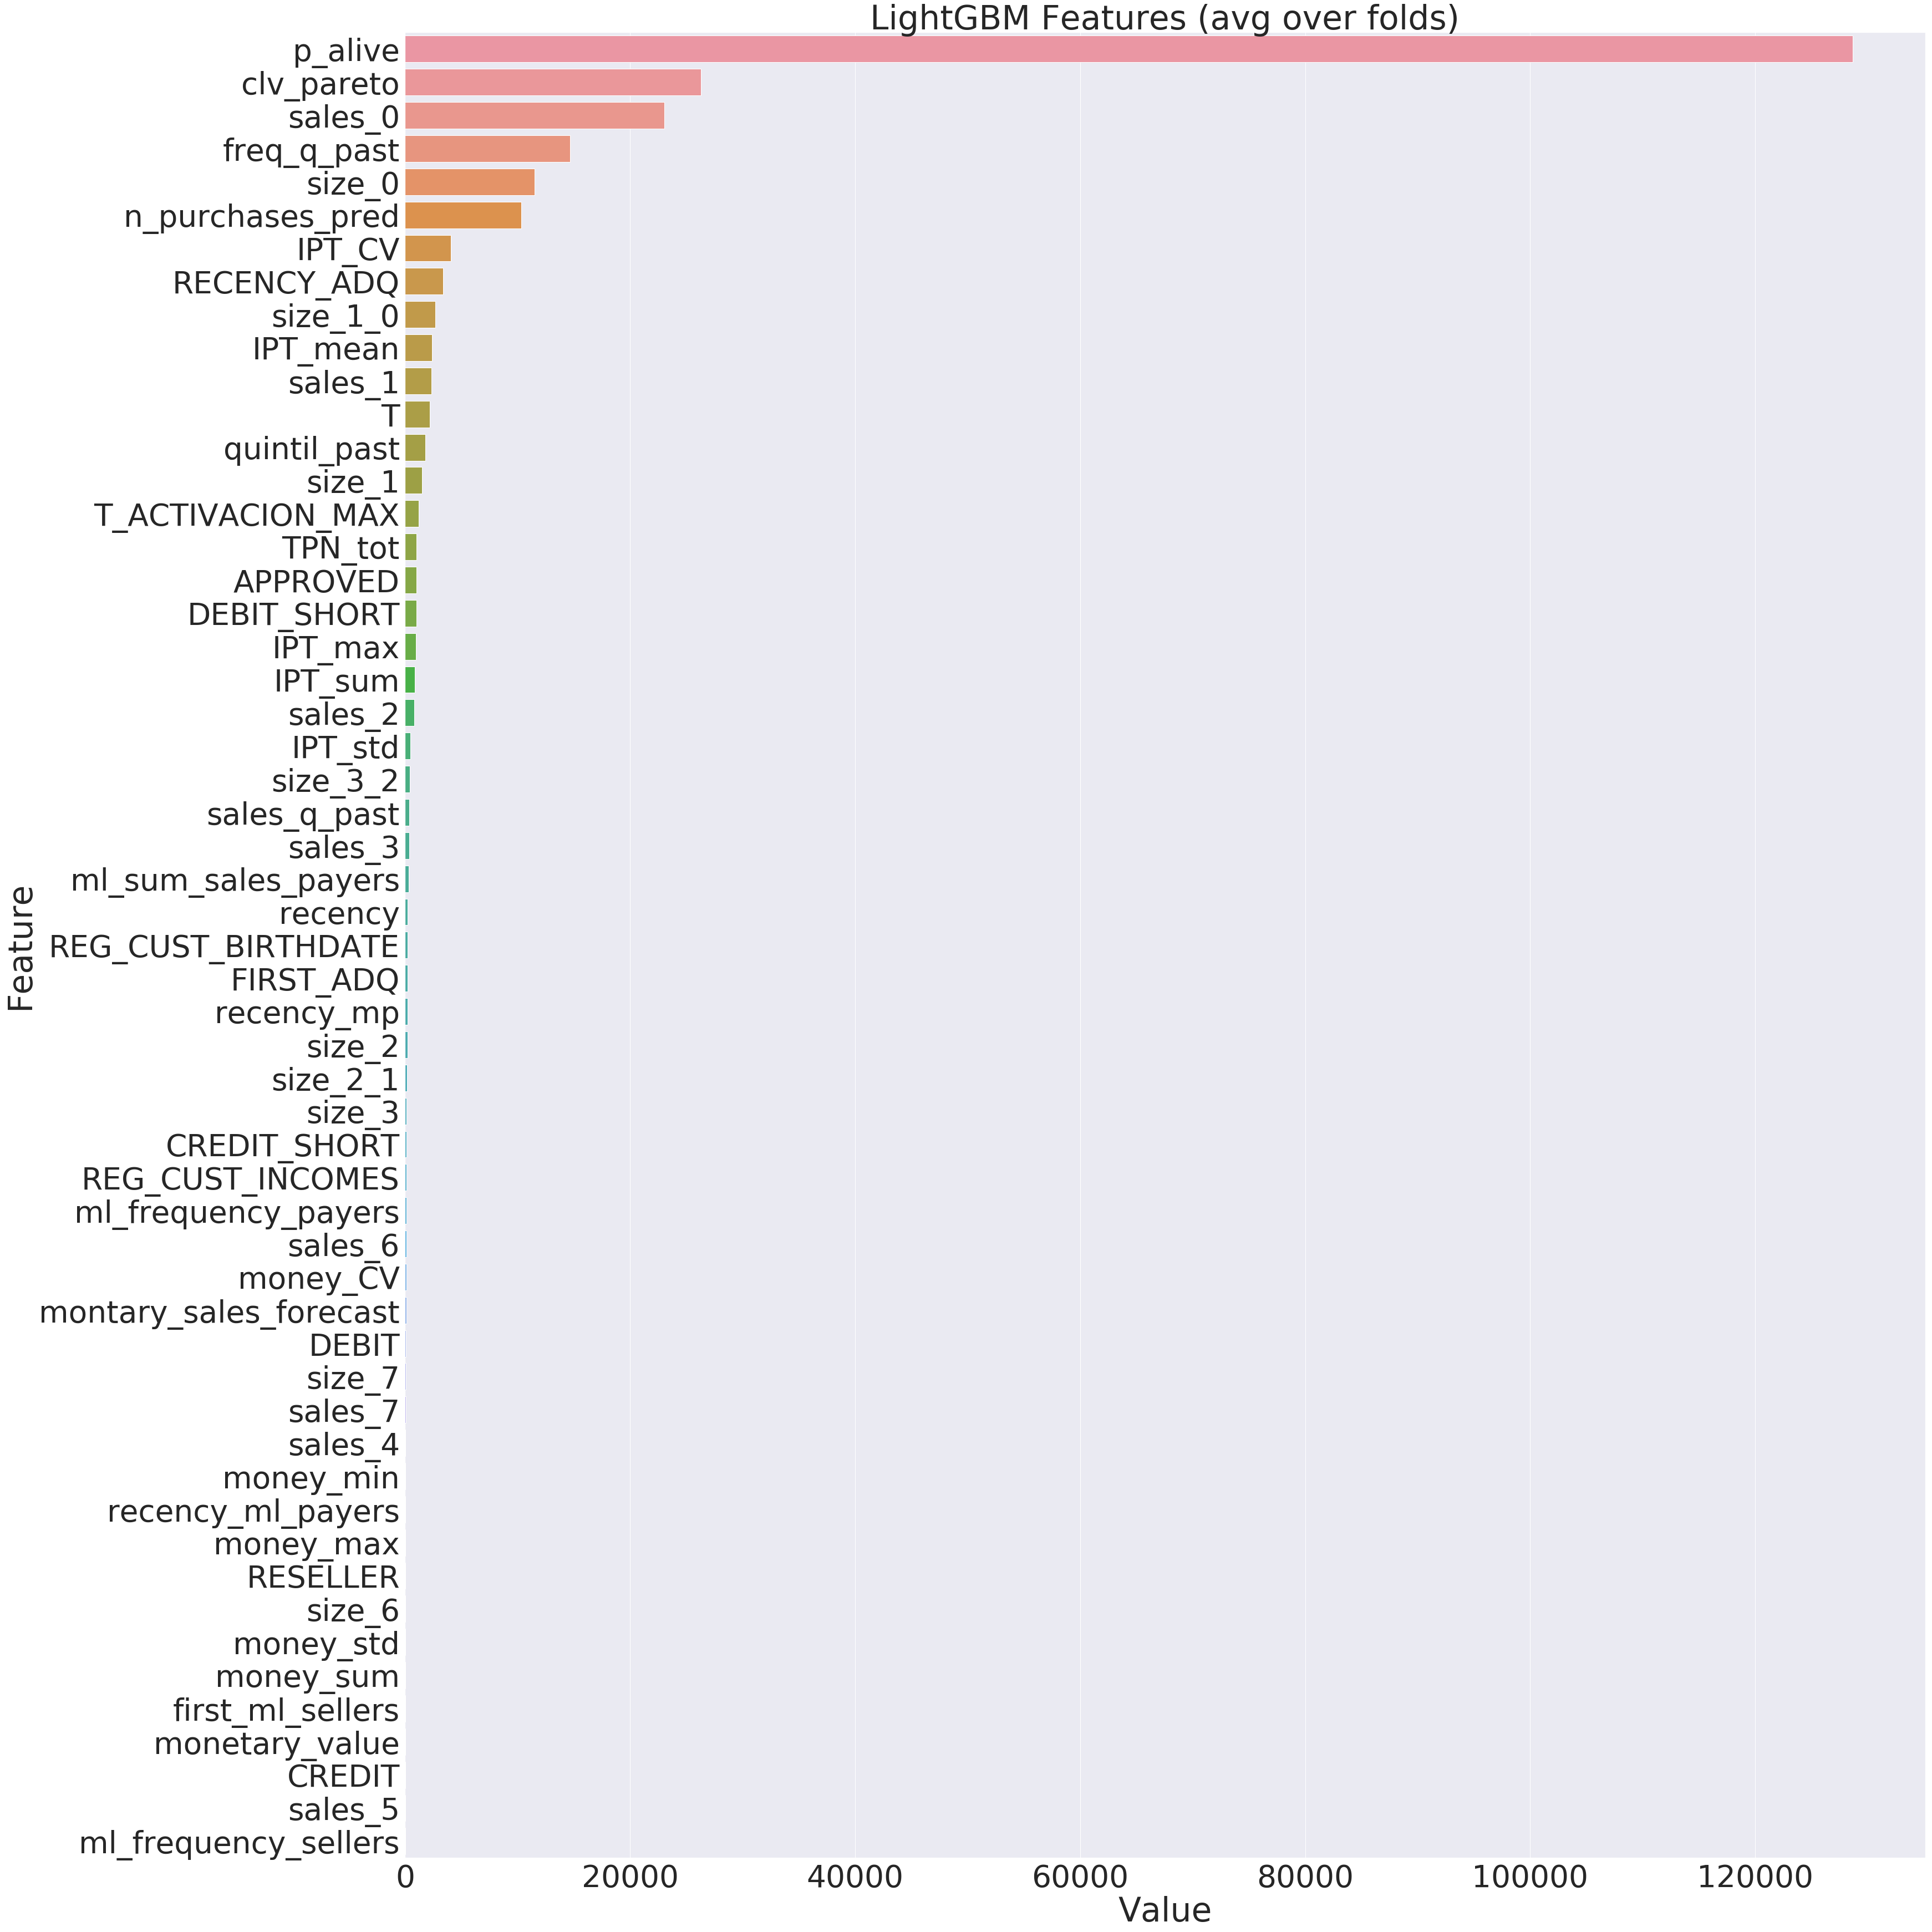

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Treshold elegido: 0.49099999999999994 Precision: 0.7239837398373984 Porcentaje alcanzado: 0.1338629809000381
Up Rate:
 0    0.759019
1    0.240981
Name: UP, dtype: float64
|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.421399
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.421524
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.421757
|  1        |  0.6239   |  0.8789   |  147.0    |  410.8    |  0.1007   |  8.287    |  8.639    |  36.24    |  24.57    |  0.7829   |
Training until 

<Figure size 432x288 with 0 Axes>

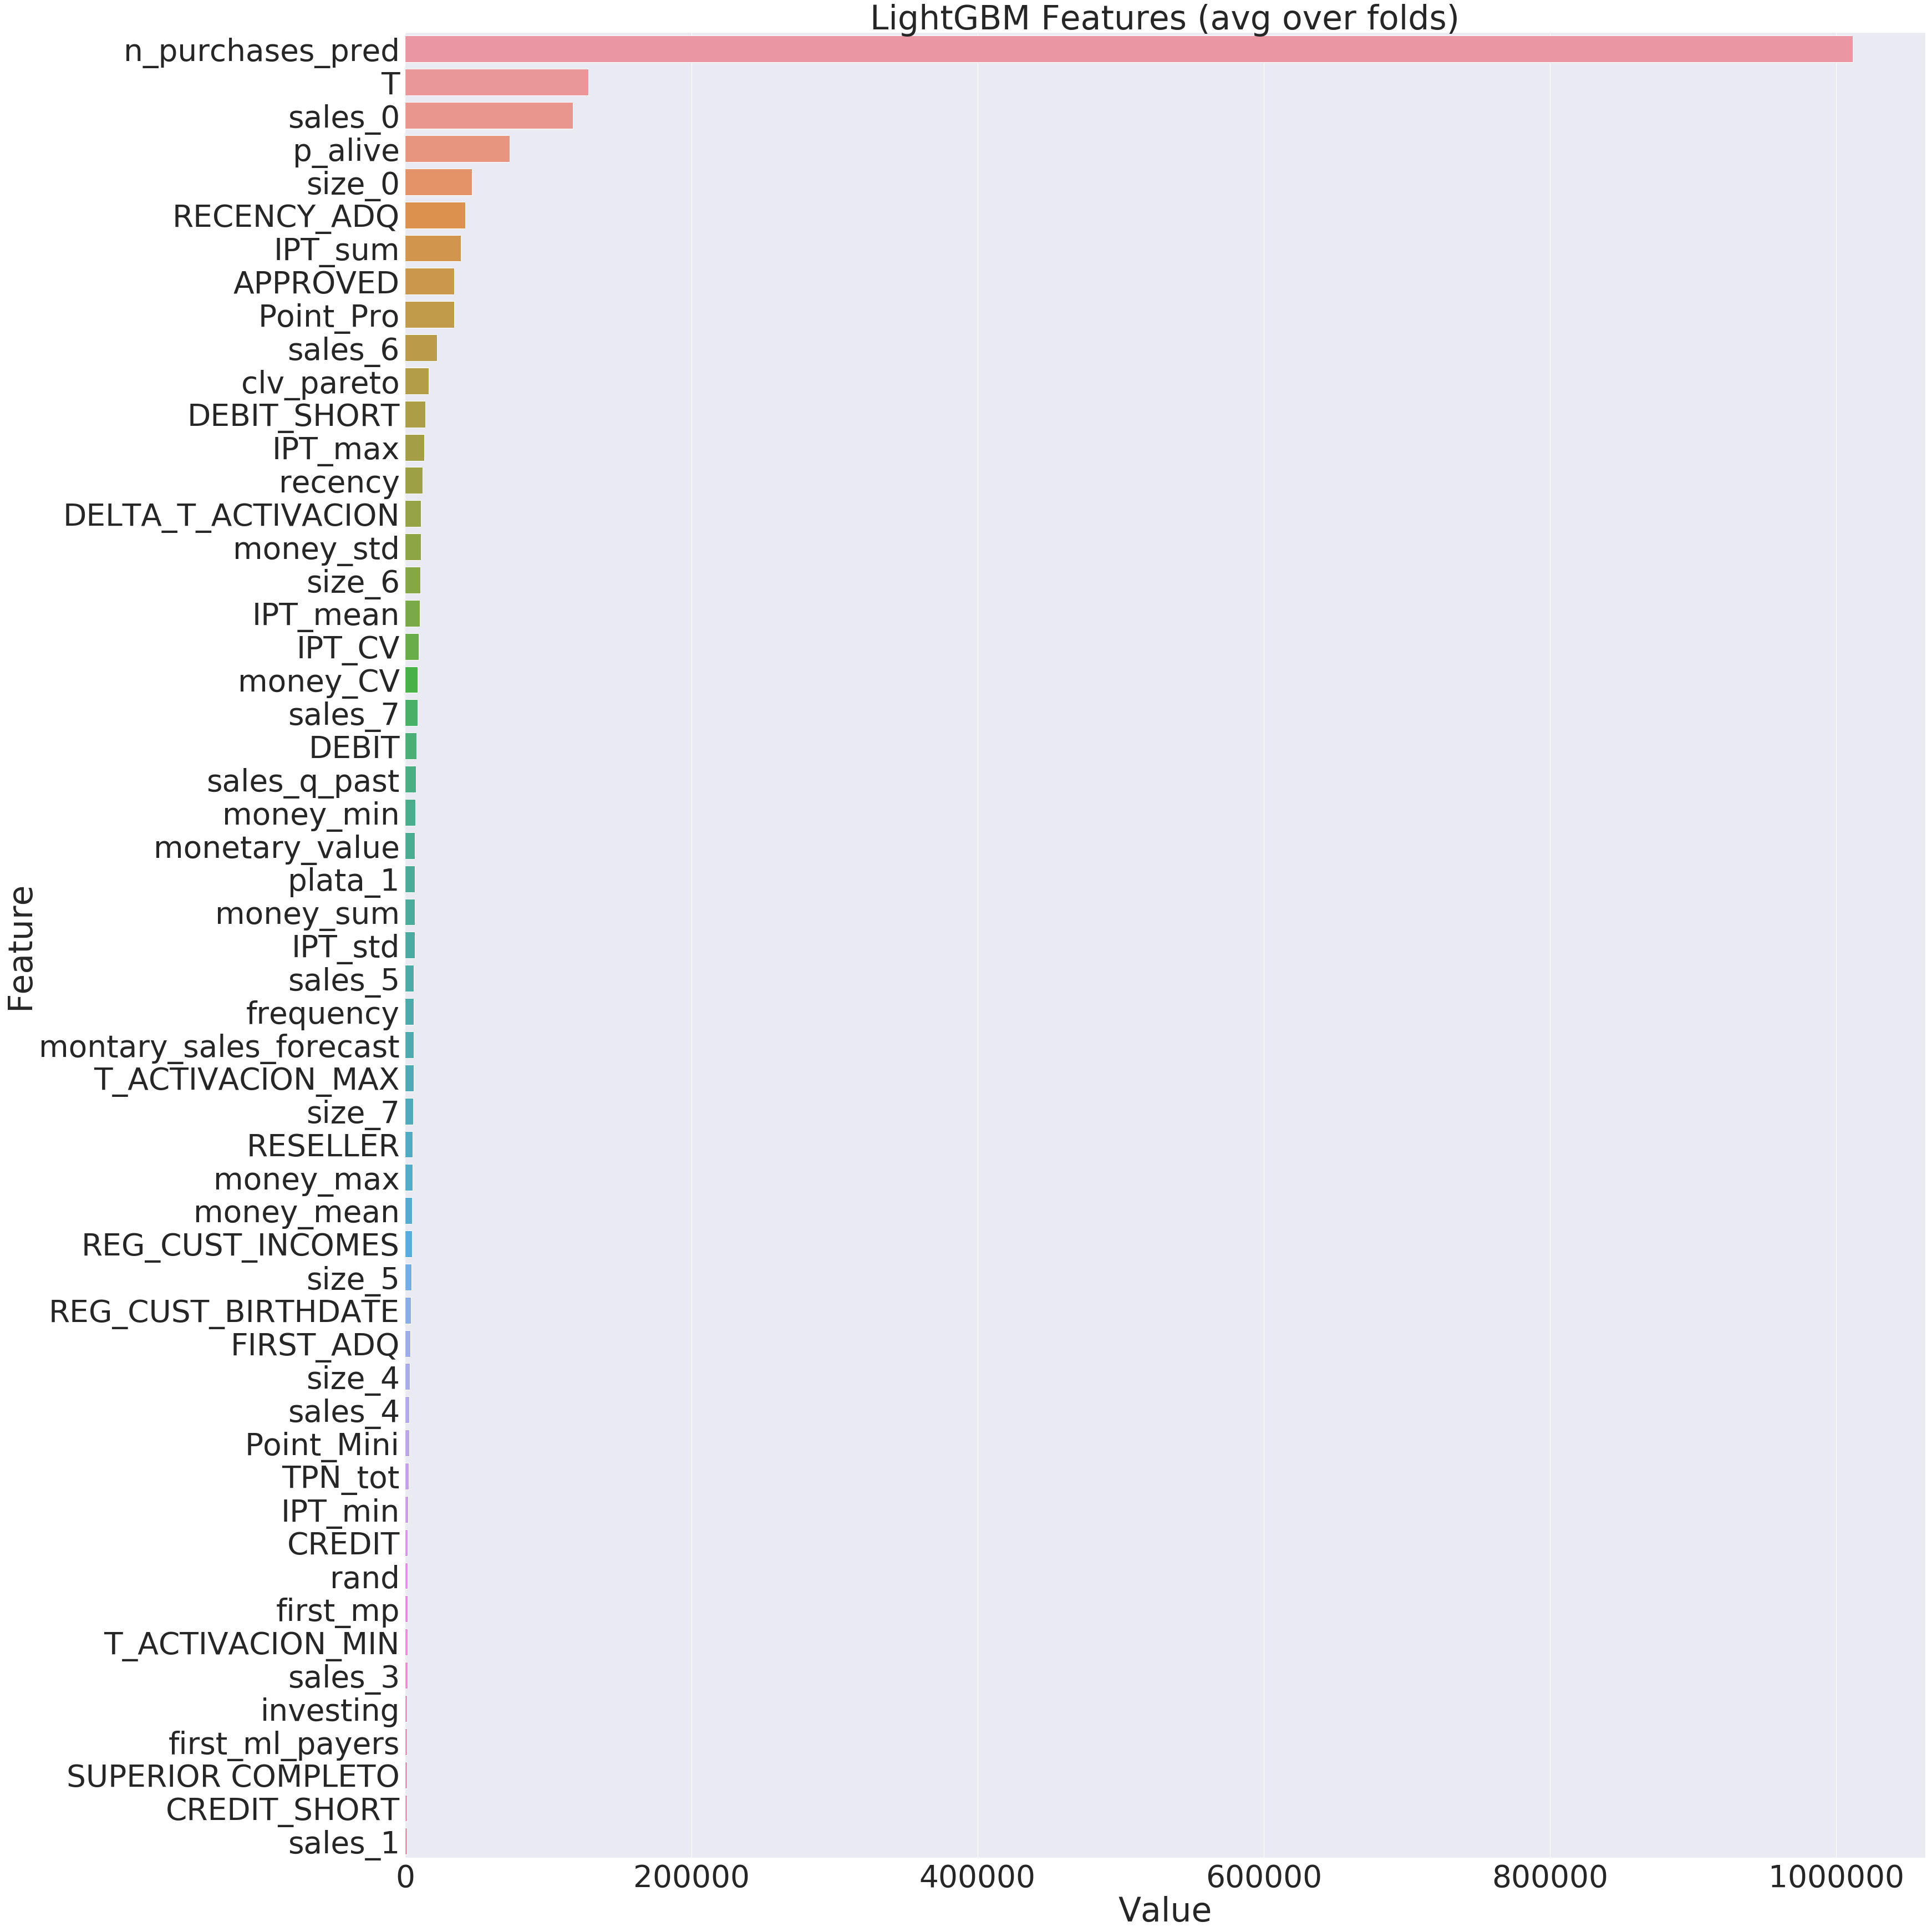

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Treshold elegido: 0.5609999999999999 Precision: 0.7131638768340566 Porcentaje alcanzado: 0.12202748707603077


NameError: name 'workspace' is not defined

<Figure size 432x288 with 0 Axes>

In [32]:

errores = {}
errores.update({"LTV":train_ltv()})
gc.collect()
errores.update({"Churn":train_churn()})
gc.collect()
errores.update({"UP":train_up()})

workspace.save_metrics(errores)


## Levanto outputs y mergeo

In [12]:
ltv_out = util.read_pickle_csv("s3://"+fda_path+s3_path_out_LTV+"LTV_resu.pkl")
churn_out = util.read_pickle_csv("s3://"+fda_path+s3_path_out_churn+"churn_resu.pkl")
up_out = util.read_pickle_csv("s3://"+fda_path+s3_path_out_up+"up_resu.pkl")

ltv_out["CUS_CUST_ID"] = ltv_out["CUS_CUST_ID"].astype(int)
ltv_out["FREQUENCY_12PAST"] = ltv_out["FREQUENCY_12PAST"].astype(int)
ltv_out["TIME_BETWEEN_FIRST_LAST"] = ltv_out["TIME_BETWEEN_FIRST_LAST"].astype(int)
ltv_out["TIME_BETWEEN_FIRST_TO_END_PERIOD"] = ltv_out["TIME_BETWEEN_FIRST_TO_END_PERIOD"].astype(int)
ltv_out["FREQUENCY_3PAST"] = ltv_out["FREQUENCY_3PAST"].astype(int)
ltv_out["LTV_SEGMENT_3PAST"] = ltv_out["LTV_SEGMENT_3PAST"].astype(int)
ltv_out["SALES_12PAST"] = ltv_out["SALES_12PAST"].apply(lambda x:round(x,4))
ltv_out["P_ALIVE"] = ltv_out["P_ALIVE"].apply(lambda x:round(x,4))
ltv_out["ASP_PRED"] = ltv_out["ASP_PRED"].apply(lambda x:round(x,4))
ltv_out["FREQUENCY_PRED"] = ltv_out["FREQUENCY_PRED"].apply(lambda x:round(x,4))
ltv_out["SALES_PRED"] = ltv_out["SALES_PRED"].apply(lambda x:round(x,4))

churn_out["CUS_CUST_ID"] = churn_out["CUS_CUST_ID"].astype(int)
churn_out["CHURN_PROBA"] = churn_out["CHURN_PROBA"].apply(lambda x:round(x,4))
churn_out["CHURN_TRESH"] = churn_out["CHURN_TRESH"].astype(int)

up_out["CUS_CUST_ID"] = up_out["CUS_CUST_ID"].astype(int)
up_out["UP_PROBA"] = up_out["UP_PROBA"].apply(lambda x:round(x,4))
up_out["UP_TRESH"] = up_out["UP_TRESH"].astype(int)

ltv_out = pd.merge(ltv_out,churn_out,on="CUS_CUST_ID",how="left")
ltv_out = pd.merge(ltv_out,up_out,on="CUS_CUST_ID",how="left")

ltv_out["PHOTO_ID"] = str(datetime.date.today().year) + str(datetime.date.today().month) +  str(datetime.date.today().day)
ltv_out["SIT_SITE_ID"] = "MLB"

ltv_out = ltv_out.sort_values(by = "FREQUENCY_PRED")
ltv_out["LTV_SEGMENT_PRED"] = asigno_quintiles(ltv_out)
ltv_out["LTV_SEGMENT_PRED"] = ltv_out.LTV_SEGMENT_PRED.str.replace("q","")

ltv_out = ltv_out[['CUS_CUST_ID', 'SIT_SITE_ID', 'PHOTO_ID',
                   'FREQUENCY_12PAST', 'TIME_BETWEEN_FIRST_LAST',
                   'TIME_BETWEEN_FIRST_TO_END_PERIOD', 'SALES_12PAST', 'FREQUENCY_3PAST',
                   'SALES_3PAST', 'LTV_SEGMENT_3PAST', 'P_ALIVE', 'ASP_PRED',
                   'FREQUENCY_PRED', 'SALES_PRED', 'LTV_SEGMENT_PRED', 'CHURN_PROBA',
                   'CHURN_TRESH', 'UP_PROBA', 'UP_TRESH']]

ltv_out.to_csv("to_tera.csv",index=False)

KeyboardInterrupt: 

In [13]:
# # Subirlo a tera...
creds = util.read_csv_from_s3("s3://"+fda_path+s3_path_in + "credentials.csv",sep = ",")

teradata_user = creds.userPas.values[0]
teradata_pass = creds.userPas.values[1]

tera = util.check_connection(teradata_user, teradata_pass)

# tera.execute("""

#     CREATE MULTISET TABLE mkt_corp.PZ_LTV_POINT,
#      NO BEFORE JOURNAL,
#      NO AFTER JOURNAL,
#      CHECKSUM = DEFAULT,
#      DEFAULT MERGEBLOCKRATIO
#      (
#         CUS_CUST_ID integer,
#         SIT_SITE_ID varchar(4),
#         PHOTO_ID integer,
#         TIME_BETWEEN_FIRST_LAST decimal(18,4),
#         TIME_BETWEEN_FIRST_TO_END_PERIOD decimal(18,4),
#         FREQUENCY_3PAST integer,
#         FREQUENCY_12PAST integer,
#         SALES_3PAST decimal(18,4),
#         SALES_12PAST decimal(18,4),
#         LTV_SEGMENT_3PAST integer,
#         P_ALIVE decimal(18,4),
#         ASP_PRED decimal(18,4),
#         FREQUENCY_PRED integer,
#         SALES_PRED decimal(18,4),
#         LTV_SEGMENT_PRED integer,
#         CHURN_PROBA decimal(18,4),
#         CHURN_TRESH decimal(18,4),
#         UP_PROBA decimal(18,4),
#         UP_TRESH decimal(18,4)
        
#       )PRIMARY INDEX ( CUS_CUST_ID,SIT_SITE_ID );    
#     """)

try:
    tera.execute("select top 1 * from mkt_corp.PZ_TMP_LTV_POINT")
    tera.execute("drop table mkt_corp.PZ_TMP_LTV_POINT")
except:
    pass

tera.execute("""

    CREATE MULTISET TABLE mkt_corp.PZ_TMP_LTV_POINT,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO
     (
        CUS_CUST_ID varchar(200),
        SIT_SITE_ID varchar(200),
        PHOTO_ID varchar(200),
        TIME_BETWEEN_FIRST_LAST varchar(200),
        TIME_BETWEEN_FIRST_TO_END_PERIOD varchar(200),
        FREQUENCY_3PAST varchar(200),
        FREQUENCY_12PAST varchar(200),
        SALES_3PAST varchar(200),
        SALES_12PAST varchar(200),
        LTV_SEGMENT_3PAST varchar(200),
        P_ALIVE varchar(200),
        ASP_PRED varchar(200),
        FREQUENCY_PRED varchar(200),
        SALES_PRED varchar(200),
        LTV_SEGMENT_PRED varchar(200),
        CHURN_PROBA varchar(200),
        CHURN_TRESH varchar(200),
        UP_PROBA varchar(200),
        UP_TRESH varchar(200)
        
      )PRIMARY INDEX ( CUS_CUST_ID,SIT_SITE_ID );    
    """)
    
tera.fast_load(file_path="to_tera.csv",table = "mkt_corp.PZ_TMP_LTV_POINT",sep = ",")

NameError: name 'ConnTeradata' is not defined

In [14]:
tera = util.check_connection(teradata_user, teradata_pass,tera = tera)

tera.execute("delete mkt_corp.PZ_LTV_POINT ALL")  # La limpio para agregar lo nuevo

tera.execute("""
   SET QUERY_BAND = 'BLOCKCOMPRESSION=YES;' FOR TRANSACTION;

   INSERT INTO mkt_corp.PZ_LTV_POINT
       SELECT  CAST(CUS_CUST_ID as integer),
               CAST( SIT_SITE_ID as varchar(4)),
               CAST(PHOTO_ID as integer),
               CAST( TIME_BETWEEN_FIRST_LAST as decimal(18,4)),
               CAST( TIME_BETWEEN_FIRST_TO_END_PERIOD as decimal(18,4)),
               CAST( FREQUENCY_3PAST as integer),
               CAST( FREQUENCY_12PAST as integer),
               CAST( SALES_3PAST as decimal(18,4)),
               CAST( SALES_12PAST as decimal(18,4)),
               CAST( LTV_SEGMENT_3PAST as integer),
               CAST( P_ALIVE as decimal(18,4)),
               CAST( ASP_PRED as decimal(18,4)),
               CAST( FREQUENCY_PRED as integer),
               CAST( SALES_PRED as decimal(18,4)),
               CAST( LTV_SEGMENT_PRED as integer),
               CAST( CHURN_PROBA as decimal(18,4)),
               CAST( CHURN_TRESH as decimal(18,4)),
               CAST( UP_PROBA as decimal(18,4)),
               CAST( UP_TRESH as decimal(18,4))
            FROM mkt_corp.PZ_TMP_LTV_POINT
        """)

NameError: name 'tera' is not defined

In [ ]:
tera = util.check_connection(teradata_user, teradata_pass,tera = tera)
tera.execute("drop table mkt_corp.PZ_TMP_LTV_POINT")

In [42]:
mgm = util.read_csv_from_s3("s3://fury-data-apps/pzenone-ltv-mp/MLB/Point_NB/Dataset/movimientos_dinero_transac.csv")

In [47]:
mgm.loc[mgm.plata >0].drop_duplicates(subset = "CUS_CUST_ID").shape

(13515, 2)

In [50]:
summary_cal = util.read_pickle_csv("s3://"+fda_path+s3_path_in+'summary_train.pkl')

print("target Rate:\n",summary_cal.target.value_counts()/summary_cal.shape[0]) # Me fijo cuantos puedo agarrar
proporcion = summary_cal.target.value_counts()[1]/summary_cal.shape[0]  # Porpocion que churnea

# Preproceso los datos
train, valid= train_test_split(summary_cal,test_size=0.15,random_state=0,stratify=summary_cal.target)
train, test= train_test_split(train,test_size=0.15,random_state=0,stratify=train.target)

stdc = StandardScaler()
stdc_trained = stdc.fit(train[train_cols])

X_train_ =  stdc_trained.transform(train[train_cols])
X_valid_ =  stdc_trained.transform(valid[train_cols])
X_test =  stdc_trained.transform(test[train_cols])

y_train_ =  np.array(train.target)
y_valid_ =  np.array(valid.target)
y_test =  np.array(test.target)  

target Rate:
 0    0.761718
1    0.238282
Name: target, dtype: float64


In [51]:
X_train_.shape

(126996, 85)

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params= {
    'class_weight':["balanced", None],
    'n_estimators': [100,200, 500,800, 1200,1800,3000,4000,5000,60000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': list(range(2, 200,40))
}

model = RandomizedSearchCV(RandomForestClassifier(n_jobs= -1), param_distributions= params, cv=3,scoring='average_precision',n_jobs = -1,verbose = 10)
model.fit(X_train_,y_train_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  5.2min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  8.5min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 11.2min remaining:  1.2min


KeyboardInterrupt: 

In [ ]:
2101.787670	CUS_FIRST_BUY
70	2020.531782	REG_CUST_INCOMES
69	1045.562185	MASCULINO
68	863.909529	eligible
67	639.380728	MAX_MONEY
66	358.220828	rio de janeiro
65	331.636251	warmup
64	320.607029	ml_sum_sales_payers
63	224.839575	sao paulo
62	191.490575	REG_CUST_BIRTHDATE
61	129.546941	MAX_IN
60	111.554502	CUS_FIRST_PUBLICATION
59	77.811461	bahia
58	74.890277	educacion
57	67.505151	FIRST_TPV
56	30.933034	mp_sum_sales_payer
55	13.069330	FEMININO
54	12.107181	investing
53	10.866530	first_ml_payers
52	8.133980	ml_SI_payers
51	6.332614	T_FRIST_VENTA
50	5.637686	recency_ml_payers